In [1]:
import re
import mdtraj as md
import mdfeature.features as features
import numpy as np
import dill
import os, glob
from mdfeature.ConvergenceAnalyser import free_energy_estimate_2D
import pyemma
from mdfeature.KramersRateEvaluator import KramersRateEvaluator
import pydiffmap.diffusion_map as dfm
import mdfeature.features as features
from time import time
import mdtraj
from pyemma.coordinates.data.featurization.angles import DihedralFeature
from mdfeature.analine_free_energy import compute_dihedral_trajectory
import matplotlib.tri as tri
#from mdfeature.general_utils import select_lowest_minima

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
font = {'family' : 'sans-serif',
        'size'   : 14.0}
mpl.rc('font', **font) 
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] =  16
mpl.rcParams['font.size'] =  15
mpl.rcParams['figure.autolayout'] =  True
mpl.rcParams['figure.figsize'] =  7.2,4.45
mpl.rcParams['axes.titlesize'] =  16
mpl.rcParams['axes.labelsize'] =  17
mpl.rcParams['lines.linewidth'] =  2
mpl.rcParams['lines.markersize'] =  6
mpl.rcParams['legend.fontsize'] =  13

- 1 reference experiment of 1us alanine dipeptide in vacuum. langevin dynamics. 300K. 1ps friction coefficient. 
- featurized the trajectory with the sin and cos components of the 4 principal dihedral angles 
- trained PCA, TICA, VAMP, DMAP on that featurized trajectory
- for PCA and TICA, first eigenvector from the eigendecomposition gives coefficients for metadynamics ES.
- for VAMP and DMAP, solved a linear regression on the leading dimension trajectory, extracted coefficients.
- ran metadynamics (using PLUMED and openmm) for 40ns for each model


### Discussion points
- error analysis for PCA, TICA, VAMP, DMAP coefficients
- what experiments to run next to get better data

Define Experiment Class

In [3]:
import openmm.unit as unit

unit_labels = {
    "us": unit.microseconds,
    "ns": unit.nanoseconds,
    "ps": unit.picoseconds,
    "fs": unit.femtoseconds
}


def parse_quantity(s):
    try:
        u = s.lstrip('0123456789.')
        v = s[:-len(u)]
        return unit.Quantity(
            float(v),
            unit_labels[u]
        )
    except Exception:
        raise ValueError(f"Invalid quantity: {s}")
        
def subsample_trajectory(trajectory, stride):
    traj = md.Trajectory(trajectory.xyz[::stride], trajectory.topology)
    return traj.superpose(traj[0]) 

def check_and_remove_nans(data, axis=1):
    num_nans = np.count_nonzero(np.isnan(data)) 
    if num_nans > 0:
        axis_str = "rows" if axis==1 else "columns"
        print(f"{num_nans} NaNs detected, removing {axis_str} with NaNs.")
        data = data[~np.isnan(data).any(axis=1), :]
        
    return data


    
class Experiment:
    
    #TODO: fix bug when default torsions = None

        def __init__(self, location, temperature, duration, savefreq, stepsize, default_torsions=None, dihedral_pickle_file=None, dihedrals=None, metad_bias_file=None):
            self.temperature = temperature
            self.duration = parse_quantity(duration)
            self.savefreq = parse_quantity(savefreq)
            self.stepsize = parse_quantity(stepsize)
            self.iterations = int(self.duration / self.stepsize)
            self.beta = 1/(self.temperature*0.0083144621)
            print("Successfully initialised experiment metadata.")
            
            self.pdb = self.load_pdb(location)
            self.topology = self.pdb.topology
            self.trajectory = self.load_trajectory(location, self.topology)
            if dihedral_pickle_file is not None:
                self.dihedral_traj = self.load_dihedral_trajectory(location, dihedral_pickle_file)
            else:
                self.dihedral_traj = self._compute_dihedral_traj(location, dihedrals)
            assert len(self.trajectory) > 0, "Trajectory is empty."
            assert len(self.dihedral_traj) > 0, "Dihedral trajectory is empty."
            if metad_bias_file is not None:
                self.metad_weights, self.bias_potential_traj = self._load_metad_bias(metad_bias_file)
                assert len(self.metad_weights) == len(self.trajectory), f"metadynamics weights (len {len(self.metad_weights)}) and trajectory (len {len(self.trajectory)}) must have the same length."
            else:
                self.metad_weights = None
            self.conformations = len(self.trajectory)
            assert np.abs(self.conformations - int(self.duration/self.savefreq)) <= 1, f"duration ({duration}) and savefreq ({savefreq}) incompatible with number of conformations found in trajectory (got {self.conformations}, expected {int(self.duration/self.savefreq)})."
            print("Successfully loaded experiment data.")
            
            self.featurizer = self.initialise_featurizer(default_torsions)
            self.featurized_trajectory = self.featurizer.transform(self.trajectory)
            self.mean_features = np.mean(self.featurized_trajectory, axis=0)
            self.fluctuations_features = np.std(self.featurized_trajectory, axis=0)
            print("Successfully featurized trajectory.")

            self.PCA = None
            self.TICA = None
            self.VAMP = None
            self.kre = KramersRateEvaluator()
            self.kre_params = {'minimum_counts':25,'bins':200,'impute_free_energy_nans':True,
                               'cluster_type':'kmeans','k':100,'ignore_high_energy_minima':False,
                              'include_endpoint_minima':True,'minima_prominence':1.5,'options':None}
            self.dmap = dfm.DiffusionMap.from_sklearn(epsilon = 'bgh', alpha = 0.5, k=64, kernel_type='gaussian', n_evecs=5, neighbor_params=None,
                             metric='euclidean', metric_params=None, weight_fxn=None, density_fxn=None, bandwidth_type="-1/(d+2)",
                             bandwidth_normalize=False, oos='nystroem')
            self.discrete_traj = None
            
        def flip_dihedral_coords(self):
            print(self.dihedral_traj.shape)
            temp = self.dihedral_traj[:,0].copy()
            self.dihedral_traj[:,0] = self.dihedral_traj[:,1]
            self.dihedral_traj[:,1] = temp
            print(self.dihedral_traj.shape)

        @staticmethod
        def _compute_dihedral_traj(loc, dihedrals):
            pdb = glob.glob(os.path.join(loc, '*.pdb'))[0]
            traj = glob.glob(os.path.join(loc, "*.dcd"))[0]
            dihedral_traj = np.array(compute_dihedral_trajectory(pdb, traj, dihedrals)).T
            # correcting order
            dihedral_traj[:,[0, 1]] = dihedral_traj[:,[1, 0]]
            return dihedral_traj
        
        def _load_metad_bias(self, bias_file, col_idx=2):
            colvar = np.genfromtxt(bias_file, delimiter=' ')
            assert col_idx < colvar.shape[1], "col_idx must not exceed 1 less than the number of columns in the bias file"
            bias_potential_traj = colvar[:,col_idx]#[::500][:-1]
            weights = np.exp(self.beta * bias_potential_traj)
            return weights, bias_potential_traj
        
        @staticmethod
        def _slice(data, quantity):
            if data is None:
                return None
            else:
                print(data[:quantity])
                return data[:quantity]
        
        @staticmethod
        def load_pdb(loc):
            print(glob.glob(os.path.join(loc)))
            pdb_files = glob.glob(os.path.join(loc, '*.pdb'))
            assert len(pdb_files) <= 1, f"Read error: more than one PDB file found in the directory ({pdb_files})."
            assert len(pdb_files) != 0, f"Read error: no PDB files found in directory."
            return md.load_pdb(pdb_files[0])
        
        @staticmethod
        def load_trajectory(loc, topology):
            traj_files = glob.glob(os.path.join(loc, '*.dcd'))
            assert len(traj_files) <= 1, f"Read error: more than one traj file found in the directory ({traj_files})."
            assert len(traj_files) != 0, f"Read error: no traj files found in directory."
            return mdtraj.load(traj_files[0], top=topology)
        
        @staticmethod
        def load_dihedral_trajectory(loc, dihedral_pickle_file):
            dihedral_traj = np.array(dill.load(open(os.path.join(loc,dihedral_pickle_file), "rb"))).T
            # correcting order
            dihedral_traj[:,[0, 1]] = dihedral_traj[:,[1, 0]]
            return dihedral_traj
        
        def initialise_featurizer(self, default_torsions):
            # To check
            featurizer = pyemma.coordinates.featurizer(self.topology)
            dihedral_indices = features.create_torsions_list(atoms=self.topology.n_atoms, size=0, append_to=default_torsions, print_list=False)
            featurizer.add_dihedrals(dihedral_indices, cossin=True)
            featurizer.describe()
            return featurizer

        def ramachandran_plot(self, data_fraction=1, bins=100, nan_threshold=50, rotate=False, low_threshold=None, save_fig=False, save_name='ramachandran_plot.pdf'):
            if self.metad_weights is None:
                dihedral_traj = check_and_remove_nans(self.dihedral_traj)
                final_iteration = int(data_fraction * len(dihedral_traj))
                free_energy, xedges, yedges = free_energy_estimate_2D(dihedral_traj[:final_iteration], self.beta, bins=bins, weights=self._slice(self.metad_weights,final_iteration))
                fig, ax = plt.subplots()
                if rotate is True:
                    free_energy = free_energy.T
                if low_threshold is None:
                    masked_free_energy = np.ma.array(free_energy, mask=(free_energy > nan_threshold))
                else:
                    masked_free_energy = np.ma.array(free_energy, mask=(np.logical_or((free_energy > nan_threshold),(free_energy < low_threshold))))
                im = ax.pcolormesh(xedges, yedges, masked_free_energy)
                cbar = plt.colorbar(im)
                cbar.set_label(r'$\mathcal{F}(\phi,\psi)$ / kJmol$^{-1}$')
                plt.xticks(np.arange(-3, 4, 1))
                plt.xlabel(r'$\phi$')
                plt.ylabel(r'$\psi$')
                plt.gca().set_aspect('equal')
            else:
                xyz = check_and_remove_nans(np.hstack([self.dihedral_traj, np.array([self.bias_potential_traj]).T]))
                x = xyz[:,0]
                y = xyz[:,1]
                z = xyz[:,2]
                fe = -z + np.max(z)
                fig, ax = plt.subplots()
                #set level increment every unit of kT
                num_levels = int(np.floor((np.max(fe)-np.min(fe)) / 2.5))
                levels = [k * 2.5 for k in range(num_levels+2)]
                if rotate is True:
                    cntr2 = ax.tricontourf(y, x, -z + np.max(z), levels=levels, cmap="RdBu_r")
                    ax.tricontour(y, x, -z, levels=levels, linewidths=0.5, colors='k')
                else:
                    cntr2 = ax.tricontourf(x, y, -z + np.max(z), levels=levels, cmap="RdBu_r")
                    ax.tricontour(x, y, -z, levels=levels, linewidths=0.5, colors='k')
                plt.xlabel(r'$\phi$')
                plt.ylabel(r'$\psi$')
                plt.gca().set_aspect('equal')
                cbar = fig.colorbar(cntr2, ax=ax)
                cbar.set_label(r'$\mathcal{F}(\phi,\psi)$ / kJmol$^{-1}$')
                ax.set(xlim=(-np.pi, np.pi), ylim=(-np.pi, np.pi))
                plt.xticks(np.arange(-3, 4, 1))
                plt.subplots_adjust(hspace=0.5)

            if save_fig:
                plt.savefig(save_name, format="pdf", bbox_inches="tight")
            plt.show()    
            
            return masked_free_energy, pd.DataFrame(np.vstack([dihedral_traj,]), columns=['phi','psi','weight'])
            
        def implied_timescale_analysis(self, max_lag=10, k=10):
            if self.discrete_traj is None:
                cluster = pyemma.coordinates.cluster_kmeans(self.featurized_trajectory, k=k)
                self.discrete_traj = cluster.dtrajs[0]
            its = pyemma.msm.its(self.discrete_traj, lags=max_lag)
            pyemma.plots.plot_implied_timescales(its)


        def compute_PCA(self, dim, stride=1, featurized=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.PCA = pyemma.coordinates.pca(trajectory, dim=dim, stride=stride)
            t1 = time()
            print(f"Computed PCA in {round(t1-t0,3)}s.")

        def compute_TICA(self, dim, lag, stride=1, featurized=True, kinetic_map=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.TICA = pyemma.coordinates.tica(trajectory, lag=lag, dim=dim, stride=stride, kinetic_map=kinetic_map)
            t1 = time()
            print(f"Computed TICA in {round(t1-t0,3)}s.")

        def compute_VAMP(self, dim, lag, stride=1, featurized=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.VAMP = pyemma.coordinates.vamp(trajectory, lag=lag, dim=dim, stride=stride)
            t1 = time()
            print(f"Computed VAMP in {round(t1-t0,3)}s.")
                
        def compute_DMAP(self, stride, featurized=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.DMAP = self.dmap.fit(trajectory[::stride])
            t1 = time()
            print(f"Computed DMAP in {round(t1-t0,3)}s.")
                
        def analyse_PCA(self, dimension, lag, sigmaD, sigmaF):
            assert self.PCA is not None, "Run compute_PCA before analyse_PCA."
            self.kre.fit(self.PCA.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize,
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
            
        def analyse_TICA(self, dimension, lag, sigmaD, sigmaF):
            assert self.TICA is not None, "Run compute_TICA before analyse_TICA."
            self.kre.fit(self.TICA.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize, 
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
        
        def analyse_VAMP(self, dimension, lag, sigmaD, sigmaF):
            assert self.VAMP is not None, "Run compute_VAMP before analyse_VAMP."
            self.kre.fit(self.VAMP.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize, 
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
            
        def eigenvector(self, CV: str, dim: int):
            self._assert_valid_cv(CV)
            x = None
            if CV == 'PCA':
                x = self.PCA.get_output()[0][:,dim]
                print(x)
                print(x.shape)
            elif CV == 'VAMP':
                x = self.VAMP.get_output()[0][:,dim]
            elif CV == 'DMAP':
                x = self.DMAP.evecs[:,dim]
                print(x)
                print(x.shape)
            elif CV == 'TICA':
                return self.TICA.eigenvectors[:,dim]
            return self._lstsq_traj_with_features(traj=x)
        
        def _lstsq_traj_with_features(self, traj):
            a = self.featurized_trajectory
            a = np.c_[np.ones(self.conformations), a]  
            print("a_shape", a.shape)
            c, err, _, _ = np.linalg.lstsq(a[::2,:], traj, rcond=None) #TODO: revert back
            
            return c[1:]
        
        def _assert_valid_cv(self, CV: str):
            assert CV in ['PCA', 'TICA', 'VAMP', 'DMAP'], "CV must be one of PCA, TICA, VAMP, DMAP."
            if CV == 'PCA':
                assert self.PCA is not None, "Run compute_PCA first."
            elif CV == 'TICA':
                assert self.TICA is not None, "Run compute_TICA first."
            elif CV == 'VAMP':
                assert self.VAMP is not None, "Run compute_VAMP first."
            elif CV == 'DMAP':
                assert self.DMAP is not None, "Run compute_DMAP first."

        def create_plumed_metadynamics_script(self, CV: str, filename=None, gaussian_height=0.2, gaussian_pace=1000):
            self._assert_valid_cv(CV)
            f = open("./plumed.py" if filename is None else f"./{filename}.py", 'w')
            output = "plumed_script=\"RESTART " + "\\n\\"
            f.write(output + "\n")
            print(output)
            dihedral_features = Dihedrals(dihedrals=self.featurizer.active_features, 
                                          offsets=self.mean_features, 
                                          coefficients=self.eigenvector(CV, dim=0))
            dihedral_features.write_torsion_labels(file=f)
            dihedral_features.write_transform_labels(file=f)
            dihedral_features.write_combined_label(CV=CV, file=f)
            self._write_metadynamics_line(height=gaussian_height, pace=gaussian_pace, CV=CV, file=f)
            
        def _write_metadynamics_line(self, height, pace, CV, file):
            arg_list = []
            sigma_list = []
            arg_list.append(f"{CV}_%d" % 0)
            sigma_list.append(str(0.1))
            output = "METAD ARG=%s SIGMA=%s HEIGHT=%s FILE=HILLS PACE=%s LABEL=metad" \
                     % (','.join(arg_list), ','.join(sigma_list), \
                        str(height), str(pace)) + " \\n\\"
            print(output)
            file.writelines(output + "\n")
            output = "PRINT ARG=%s,metad.bias STRIDE=%s FILE=COLVAR" % (','.join(arg_list), str(pace)) + " \\n"
            print(output + "\"")
            file.writelines(output + "\"" + "\n")
            file.close()

[-0.00016758 -0.00016758 -0.00016758 ... -0.00016758 -0.00016758
 -0.00016758]
(493518,)


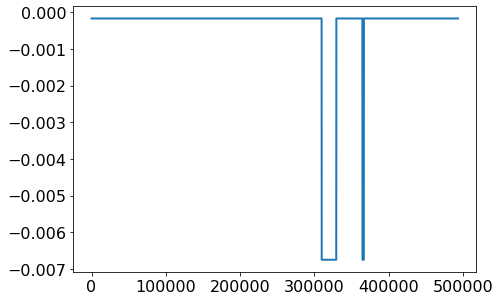

a_shape (987036, 9)
[-1.14788408e-03 -3.13158735e-03 -5.37732209e-05  8.82056193e-05
 -3.85639426e-04  1.81628914e-04 -2.97181561e-05 -4.01716128e-05]


In [28]:
x = alanine_exp_1us_w_dmap.DMAP.evecs[:,0]
print(x)
print(x.shape)
plt.plot(x)
plt.show()
print(alanine_exp_1us_w_dmap._lstsq_traj_with_features(traj=x))

Tasks to do

2) TICA with and without Dihedral Featurizer
3) OpenMM metadynamics - in what form do the collective variables need to be given?
5) Diffusion maps vs. TICA vs. VAMPnet trajectories Kramers Rate in ring double well
6) Diffusion maps vs. TICA vs. VAMPnet trajectories Kramers Rate in alanine dipeptide

4) Learn collective variables from 20ns alanine dipeptide trajectory

In [98]:
#pdb_file = '../data/alanine.pdb'
#trajectory = '../data/outputs/alanine_20ns/trajectory.dcd'
location = '../data/outputs/alanine_20ns'
dihedral_pickle_file = 'alanine_20ns_dihedral_traj.pickle'
temperature = 300
duration = "20ns" 
savefreq = "0.1ps"
stepsize = "2fs"
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]
default_torsions = [phi, psi, zeta, theta]
alanine_exp_20ns = Experiment(location = location, 
                              dihedral_pickle_file = dihedral_pickle_file,
                              temperature = temperature,
                              duration = duration,
                              savefreq = savefreq,
                              stepsize = stepsize,
                              default_torsions=default_torsions
                              )

Successfully initialised experiment metadata.
['/home/dominic/PycharmProjects/mdfeature/data/outputs/alanine_1us']


FileNotFoundError: [Errno 2] No such file or directory: '/home/dominic/PycharmProjects/mdfeature/data/outputs/alanine_1us/alanine_20ns_dihedral_traj.pickle'

6 NaNs detected, removing rows with NaNs.


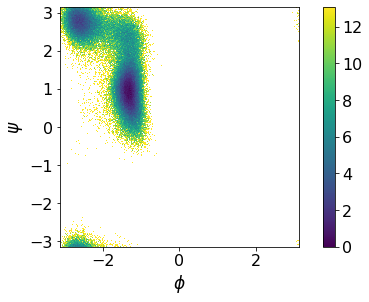

In [533]:
alanine_exp_20ns.ramachandran_plot(rotate=True, bins=300)

In [4]:
location = '/home/dominic/PycharmProjects/mdfeature/data/outputs/alanine_1us'#'../data/outputs/alanine_1us'
dihedral_pickle_file = 'alanine_1us_dihedral_traj.pickle'
temperature = 300
duration = "987.036ns" 
savefreq = "1ps"
stepsize = "2fs"
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]
default_torsions = [phi, psi, zeta, theta]
alanine_exp_1us = Experiment(location = location, 
                              dihedral_pickle_file = dihedral_pickle_file,
                              temperature = temperature,
                              duration = duration,
                              savefreq = savefreq,
                              stepsize = stepsize,
                              default_torsions=default_torsions
                              )

Successfully initialised experiment metadata.
['/home/dominic/PycharmProjects/mdfeature/data/outputs/alanine_1us']
Successfully loaded experiment data.
Successfully featurized trajectory.


In [5]:
alanine_exp_1us.compute_PCA(dim = 3, stride=1)
alanine_exp_1us.compute_TICA(dim = 3, lag=64, stride=1)
alanine_exp_1us.compute_VAMP(dim = 3, lag=64, stride=1)
#alanine_exp_1us.compute_DMAP(stride=2)

Computed PCA in 0.065s.
Computed TICA in 0.209s.
Computed VAMP in 0.127s.


Debug: default clustering None, num default clusters None, k 100


initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

estimating MaximumLikelihoodMSM:   0%|                                                                        …

1 <class 'int'>
[0.21931657 0.22245548 0.21231115 0.21272714 0.20073931 0.18892775
 0.18164958 0.17324035 0.16470123 0.15317645 0.14083818 0.13171054
 0.12341417 0.11134591 0.10175837 0.09998937 0.09432236 0.09046562
 0.0863361  0.08191327 0.07777718 0.07643049 0.07444183 0.07377698
 0.07202837 0.07050343 0.07290432 0.06934552 0.06896433 0.072028
 0.06852035 0.06812017 0.0734988  0.07475205 0.07265089 0.07480552
 0.0730726  0.07868446 0.07938297 0.08237145 0.08687093 0.08806387
 0.09479733 0.09596014 0.1104788  0.11682709 0.12295478 0.13816553
 0.14898504 0.15870265 0.18147846 0.19820629 0.21933044 0.23876344
 0.25978605 0.27320987 0.29324365 0.30270565 0.31782661 0.33634451
 0.33879976 0.34960488 0.36060277 0.36191069 0.3666118  0.3683705
 0.37189261 0.38152438 0.38795088 0.39725761 0.40114428 0.41352793
 0.41362769 0.41792019 0.40749569 0.37868346 0.35391561 0.32559583
 0.28448454 0.25194382 0.23170931 0.20293898 0.18391623 0.16035881
 0.15270046 0.14320331 0.13538703 0.12972748 0.12

50 <class 'int'>
[0.00721059 0.00711114 0.0072164  0.00710812 0.00716131 0.00720689
 0.00704512 0.00710393 0.00711498 0.00703504 0.00704157 0.00701531
 0.00699949 0.00694771 0.00692439 0.00693355 0.00695717 0.00698829
 0.00682339 0.00690402 0.00685363 0.00682904 0.00683418 0.00684865
 0.00678143 0.00679173 0.00678263 0.00676231 0.00676731 0.00674504
 0.00673203 0.00672862 0.00665594 0.00666254 0.00661768 0.0066315
 0.00659034 0.0066118  0.00655614 0.00655032 0.0066582  0.0065697
 0.00661692 0.00653545 0.0066285  0.0066113  0.00656108 0.00663304
 0.00662342 0.00668129 0.00675845 0.00681744 0.0068175  0.00690523
 0.00697395 0.00710022 0.00709122 0.00706784 0.00695732 0.00717012
 0.00705188 0.0070339  0.00720609 0.00731652 0.00709591 0.0070942
 0.00714209 0.00719992 0.00718811 0.00715977 0.00701417 0.00706407
 0.00716033 0.00707595 0.00717008 0.00722621 0.0072106  0.0072132
 0.00718183 0.00717529 0.00719675 0.0070372  0.00719589 0.00720776
 0.00711771 0.00714037 0.00719954 0.00715435 0.00

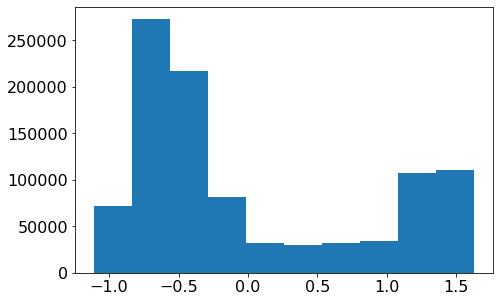

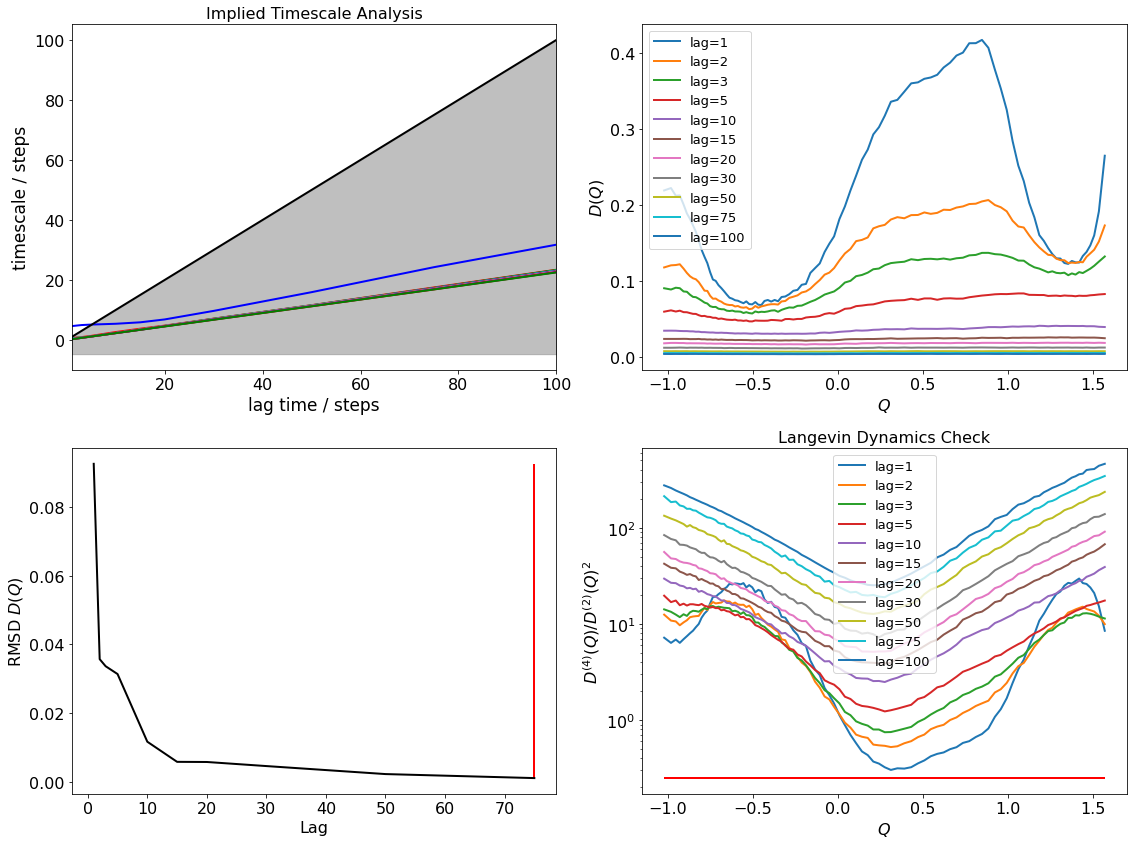

1 <class 'int'>
[0.21931657 0.22245548 0.21231115 0.21272714 0.20073931 0.18892775
 0.18164958 0.17324035 0.16470123 0.15317645 0.14083818 0.13171054
 0.12341417 0.11134591 0.10175837 0.09998937 0.09432236 0.09046562
 0.0863361  0.08191327 0.07777718 0.07643049 0.07444183 0.07377698
 0.07202837 0.07050343 0.07290432 0.06934552 0.06896433 0.072028
 0.06852035 0.06812017 0.0734988  0.07475205 0.07265089 0.07480552
 0.0730726  0.07868446 0.07938297 0.08237145 0.08687093 0.08806387
 0.09479733 0.09596014 0.1104788  0.11682709 0.12295478 0.13816553
 0.14898504 0.15870265 0.18147846 0.19820629 0.21933044 0.23876344
 0.25978605 0.27320987 0.29324365 0.30270565 0.31782661 0.33634451
 0.33879976 0.34960488 0.36060277 0.36191069 0.3666118  0.3683705
 0.37189261 0.38152438 0.38795088 0.39725761 0.40114428 0.41352793
 0.41362769 0.41792019 0.40749569 0.37868346 0.35391561 0.32559583
 0.28448454 0.25194382 0.23170931 0.20293898 0.18391623 0.16035881
 0.15270046 0.14320331 0.13538703 0.12972748 0.12

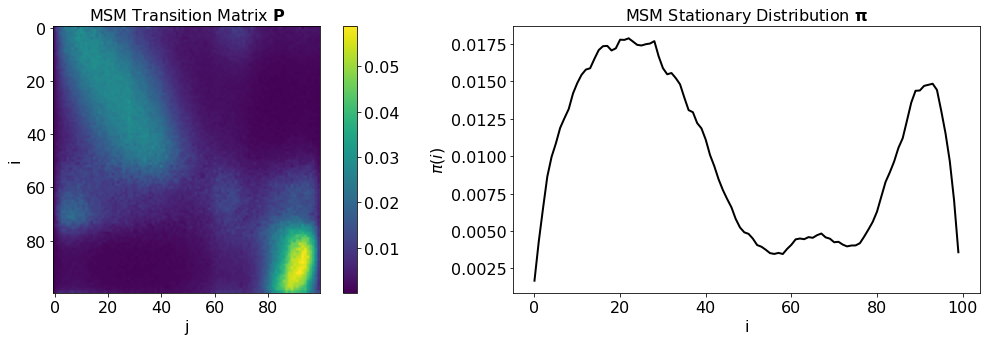

Free energy profile suggests 2 minima.
Minima  (-0.63, 0.008)
Minima  (1.41, 1.142)


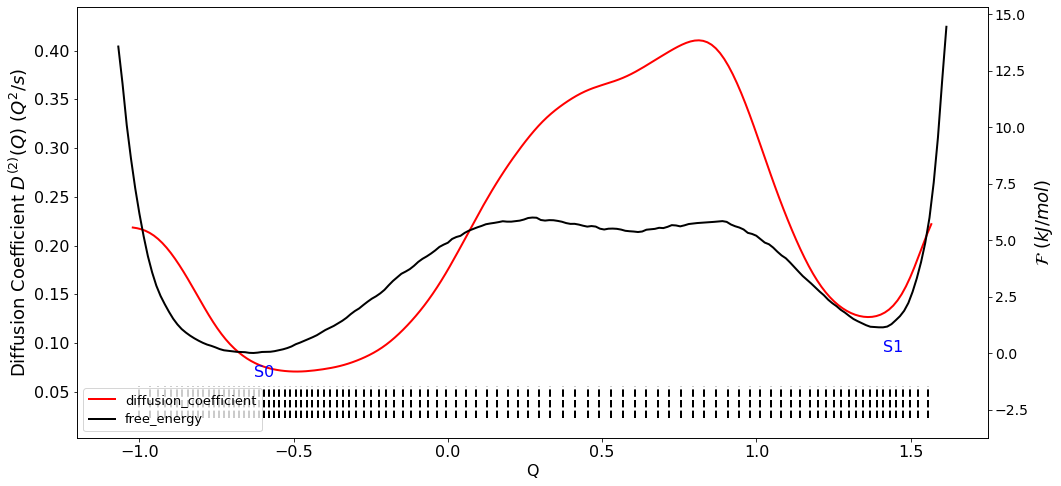

Kramer's Rates
-------------------------
S0 --> S1 : 4.973933e-02
S1 --> S0 : 8.796815e-02
-------------------------


[((0, 1), 0.04973933284855688), ((1, 0), 0.08796814690583256)]

In [20]:
plt.hist(alanine_exp_1us.PCA.get_output()[0][:,0])
kre = KramersRateEvaluator()
kre.fit(alanine_exp_1us.PCA.get_output()[0][:,0],
       beta=1/(300*0.0083144621),
       time_step=1,
       lag=1,
       sigmaD=0.05,
       k=100,
       sigmaF=0.01)

Note: Of the 200 free energy evaluations, 84 were NaN values.
Debug: default clustering None, num default clusters None, k 100


/home/dominic/PycharmProjects/mdfeature/src/mdfeature/KramersRateEvaluator.py:33: UserWarning: NaN values were found in the free energy calculation. Consider using a longer trajectory or rerunning with fewer bins (currently bins=200). Fixing with imputation for now.
  warnings.warn(f"NaN values were found in the free energy calculation. "


initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

13-08-22 16:12:51 pyemma.coordinates.clustering.kmeans.KmeansClustering[70] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 150 iterations. Consider increasing max_iter.


/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 150 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


estimating MaximumLikelihoodMSM:   0%|                                                                        …

1 <class 'int'>
[0.04298028 0.04253661 0.04195452 0.04104337 0.03902721 0.03853087
 0.03761362 0.03561377 0.03614637 0.03400582 0.03412557 0.03378707
 0.03295361 0.03177142 0.03170306 0.03138626 0.0312829  0.02995536
 0.0303192  0.02982511 0.02995883 0.02968003 0.0291609  0.0295368
 0.0293636  0.02916124 0.02894125 0.02936585 0.02949942 0.02918788
 0.02904481 0.02913707 0.02926573 0.02933371 0.02949017 0.02924473
 0.02927798 0.02902855 0.02949408 0.02944786 0.03000698 0.02987745
 0.02995082 0.03058925 0.02985801 0.03108674 0.03110377 0.03022353
 0.03077665 0.03094659 0.03257188 0.03243243 0.03226293 0.03282591
 0.03331497 0.03259907 0.03394738 0.03378033 0.03485411 0.03483174
 0.034587   0.03524793 0.03530888 0.03630517 0.0360561  0.0360294
 0.03718798 0.03724724 0.0367485  0.03801673 0.0387566  0.03971535
 0.04032267 0.03943447 0.04128955 0.04218858 0.04094223 0.0425484
 0.04206987 0.0429896  0.0448115  0.0442162  0.04543267 0.04715106
 0.04424303 0.04431766 0.04903088 0.05659963 0.00

50 <class 'int'>
[6.67437310e-04 6.39150536e-04 6.52432919e-04 6.92315243e-04
 6.55065293e-04 6.67344839e-04 6.62246745e-04 6.56156091e-04
 6.47460658e-04 6.60529474e-04 6.40561333e-04 6.64013053e-04
 6.77439507e-04 6.69553559e-04 6.52131140e-04 6.50324903e-04
 6.53974275e-04 6.77979142e-04 6.46873268e-04 6.49078953e-04
 6.66054007e-04 6.57760104e-04 6.51237324e-04 6.50161718e-04
 6.55827521e-04 6.54368817e-04 6.64415039e-04 6.67908049e-04
 6.61684266e-04 6.75793961e-04 6.49665952e-04 6.60615587e-04
 6.69930496e-04 6.52042758e-04 6.66638453e-04 6.67260683e-04
 6.65116811e-04 6.84914664e-04 6.42814211e-04 6.70416739e-04
 6.35697074e-04 6.62341083e-04 6.55948935e-04 6.63423728e-04
 6.46265609e-04 6.63985376e-04 6.50393239e-04 6.55251567e-04
 6.49299138e-04 6.51637063e-04 6.75312702e-04 6.49592356e-04
 6.69391034e-04 6.78407216e-04 6.58723947e-04 6.77928031e-04
 6.81506316e-04 6.68809003e-04 6.68787936e-04 6.67846271e-04
 6.57917868e-04 6.49285804e-04 6.73659766e-04 6.54956005e-04
 6.6321

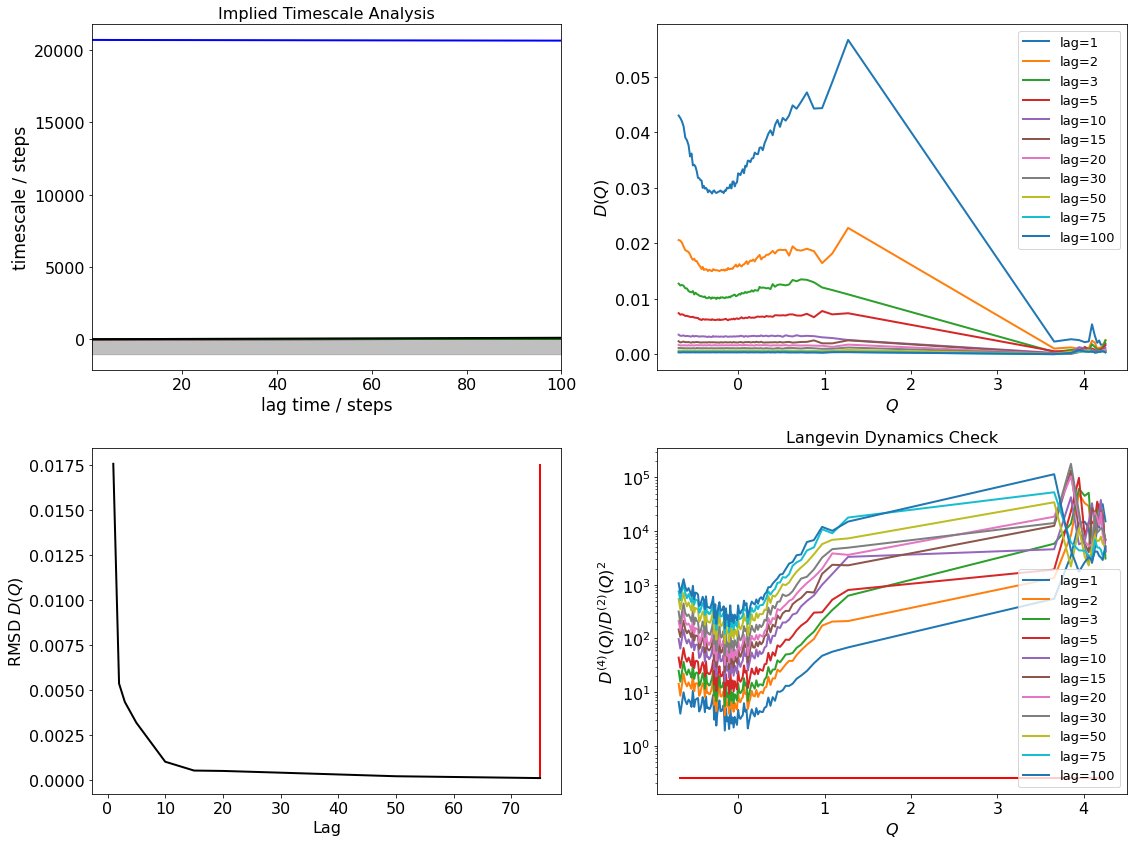

15 <class 'int'>
[0.0023398  0.00212226 0.00220593 0.0022776  0.00218413 0.00217105
 0.00219858 0.00213322 0.00209908 0.00220801 0.0021248  0.00218798
 0.00220387 0.00218897 0.00214155 0.00212636 0.0021117  0.00215447
 0.00212721 0.00214033 0.00214964 0.00210909 0.00216239 0.00217111
 0.00213248 0.00215162 0.00217113 0.0021347  0.0021604  0.00213947
 0.00213086 0.00210748 0.0021485  0.00207776 0.00215982 0.00216064
 0.00210503 0.00214089 0.00215651 0.00217145 0.00212227 0.00215394
 0.00213485 0.00217212 0.00213662 0.00211245 0.00220781 0.0021287
 0.00214869 0.0021104  0.00212488 0.00217417 0.00219992 0.00217421
 0.00209819 0.00214132 0.00218795 0.00217982 0.00218379 0.00220787
 0.00213155 0.00214812 0.00221034 0.0021411  0.00225272 0.00216137
 0.00216395 0.00225391 0.00212393 0.00211197 0.00214088 0.00212836
 0.00215274 0.00215171 0.00217478 0.00212922 0.0022077  0.00211168
 0.0021805  0.00222084 0.00210165 0.00214395 0.00221622 0.00223087
 0.00250236 0.00197153 0.00196032 0.00251324 0

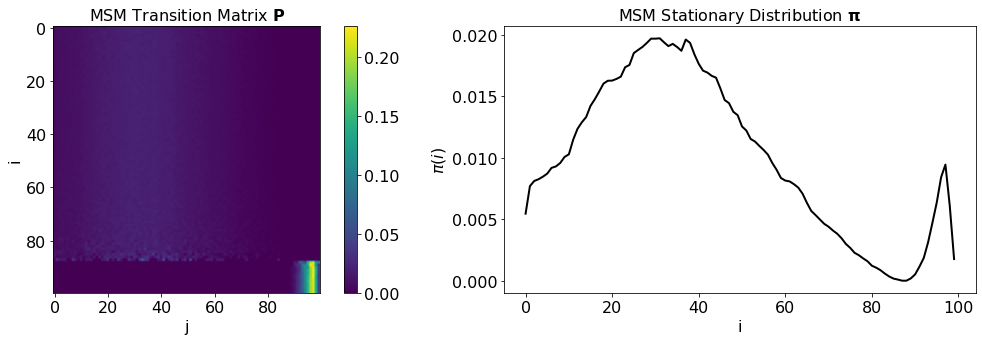

Free energy profile suggests 3 minima.
Minima  (-0.238, 0.004)
Minima  (3.578, 22.566)
Minima  (4.184, 3.249)


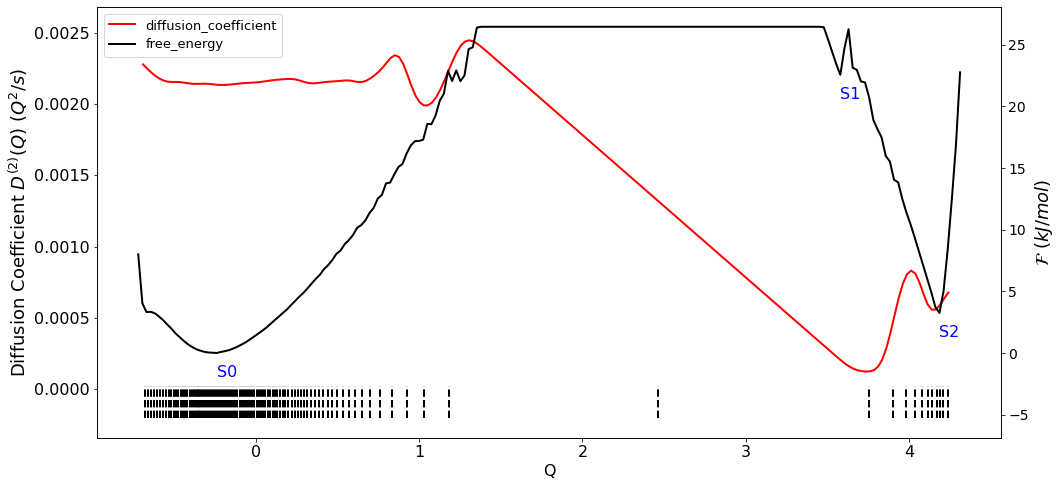

Kramer's Rates
-------------------------
S0 --> S1 : 3.532625e-08
S0 --> S2 : 2.938079e-08
S1 --> S0 : 2.129113e-04
S1 --> S2 : 4.158420e-04
S2 --> S0 : 4.797910e-07
S2 --> S1 : 3.183399e-06
-------------------------


[((0, 1), 3.5326254307382535e-08),
 ((0, 2), 2.9380786525185148e-08),
 ((1, 0), 0.00021291133312946554),
 ((1, 2), 0.00041584198574885),
 ((2, 0), 4.797909825021429e-07),
 ((2, 1), 3.1833988498240007e-06)]

In [18]:
kre = KramersRateEvaluator()
kre.fit(alanine_exp_1us.TICA.get_output()[0][:,0],
       beta=1/(300*0.0083144621),
       time_step=1,
       lag=15,
       sigmaD=0.05,
       k=100,
       sigmaF=0.01)

Note: Of the 200 free energy evaluations, 85 were NaN values.
Debug: default clustering None, num default clusters None, k 100


/home/dominic/PycharmProjects/mdfeature/src/mdfeature/KramersRateEvaluator.py:33: UserWarning: NaN values were found in the free energy calculation. Consider using a longer trajectory or rerunning with fewer bins (currently bins=200). Fixing with imputation for now.
  warnings.warn(f"NaN values were found in the free energy calculation. "


initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

estimating MaximumLikelihoodMSM:   0%|                                                                        …

1 <class 'int'>
[0.0502099  0.04886783 0.05027079 0.04816426 0.04755805 0.04552884
 0.04544081 0.04433656 0.04193536 0.04190372 0.04078709 0.03990495
 0.03902321 0.03907712 0.03732612 0.03667427 0.03705179 0.036461
 0.03498644 0.03537224 0.03485827 0.03501634 0.03437819 0.0341538
 0.03458747 0.03381755 0.0341506  0.0338463  0.03458977 0.03417642
 0.03402977 0.03388705 0.03388145 0.03419171 0.03430907 0.03446725
 0.03413833 0.03415757 0.03387483 0.03414728 0.03451445 0.03486915
 0.03487014 0.03492287 0.03545727 0.03525239 0.03596772 0.0361673
 0.03536202 0.03622286 0.03635001 0.03809972 0.03749718 0.03847228
 0.03882367 0.03833006 0.03960221 0.03973928 0.04108585 0.04084467
 0.04061225 0.04143842 0.04217515 0.04243083 0.04195262 0.04336063
 0.04374347 0.04340422 0.04437832 0.0454299  0.04696979 0.0466386
 0.0471815  0.04789046 0.04990143 0.04731264 0.05027905 0.04951011
 0.05215552 0.05195182 0.05120671 0.05284928 0.05477536 0.05328526
 0.0504819  0.05707201 0.07277937 0.00228139 0.0033

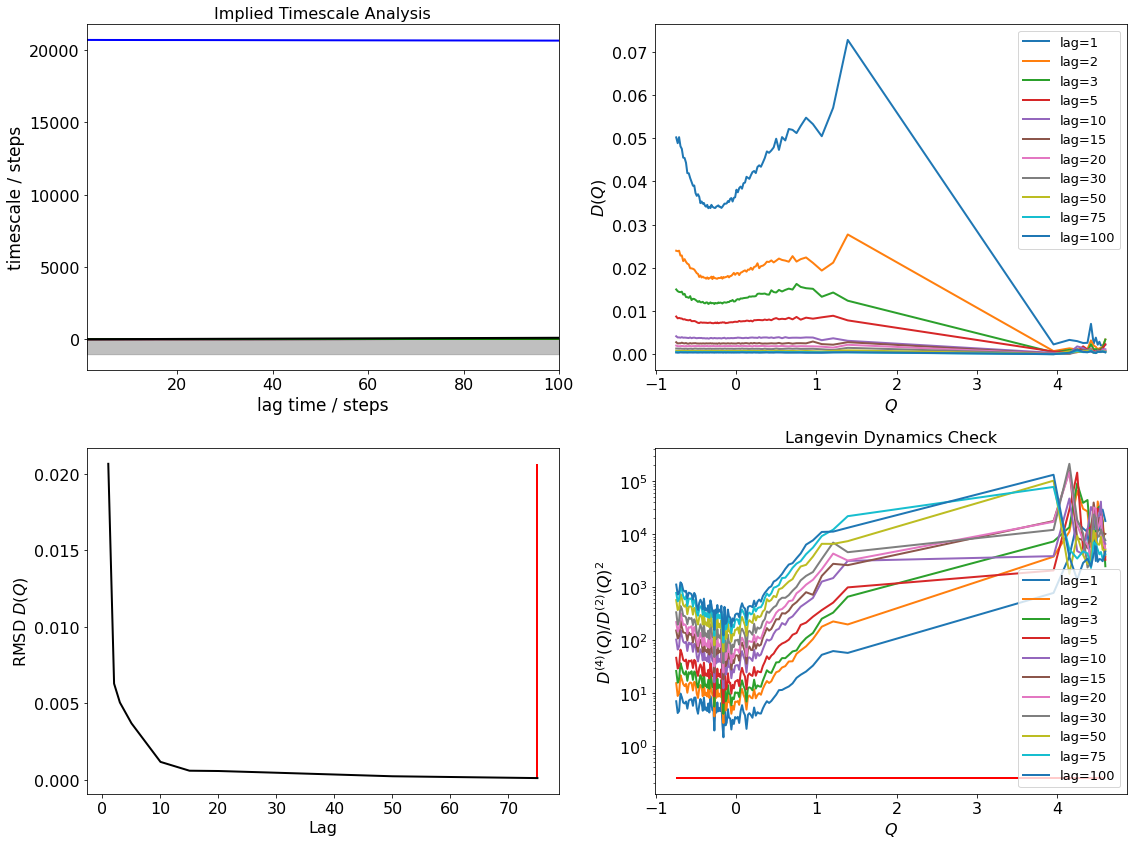

15 <class 'int'>
[0.00279064 0.00250033 0.00255392 0.00254408 0.00267894 0.00256249
 0.00252344 0.00259742 0.0024644  0.00246012 0.00257865 0.00248462
 0.0025435  0.00255321 0.00256895 0.00249928 0.00249693 0.00247802
 0.00250825 0.00248162 0.00251324 0.00250895 0.002472   0.00253254
 0.00250239 0.00251206 0.00250394 0.00255077 0.00248762 0.00252793
 0.00247648 0.0024931  0.00246718 0.00250383 0.00242546 0.00251777
 0.0025534  0.00243877 0.00249945 0.00251518 0.00253167 0.00251199
 0.00249031 0.00249192 0.00254567 0.0025053  0.00248549 0.00253953
 0.00249748 0.00249844 0.0024824  0.00248781 0.00256353 0.00256619
 0.00244523 0.00254447 0.00250547 0.00256643 0.00257182 0.00252394
 0.00246374 0.0025971  0.00250337 0.00261805 0.00253166 0.00253191
 0.00260335 0.00250828 0.00246386 0.00249795 0.00247863 0.00250268
 0.00254685 0.00250669 0.00250613 0.00262267 0.00245259 0.00252887
 0.00259823 0.00245553 0.00255501 0.00256121 0.00252585 0.00295411
 0.00235066 0.00221532 0.00279461 0.00012361 

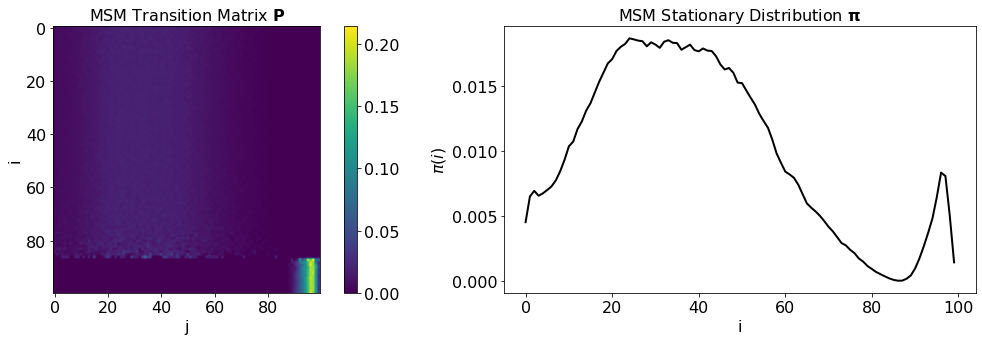

Free energy profile suggests 3 minima.
Minima  (-0.257, 0.003)
Minima  (3.865, 23.032)
Minima  (4.521, 3.157)


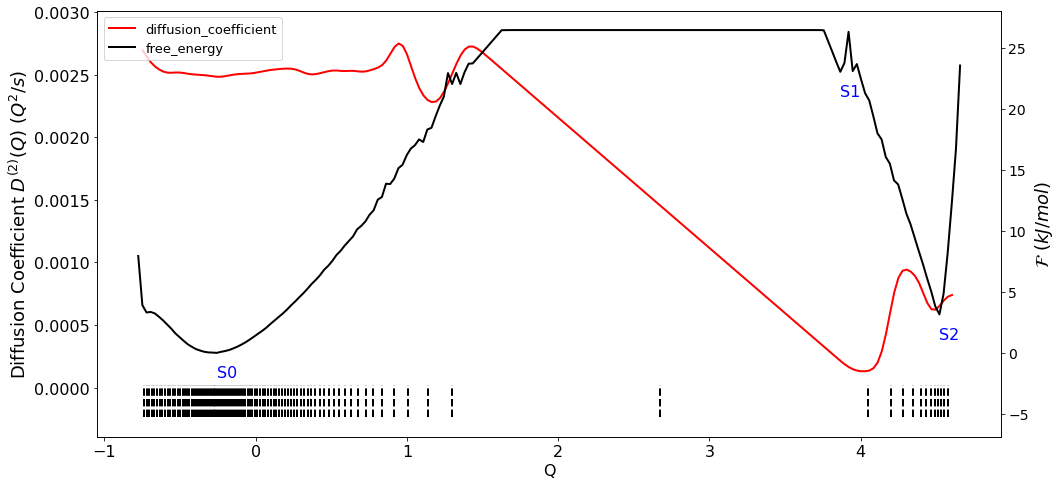

Kramer's Rates
-------------------------
S0 --> S1 : 3.358607e-08
S0 --> S2 : 2.761668e-08
S1 --> S0 : 2.052946e-04
S1 --> S2 : 3.653171e-04
S2 --> S0 : 4.598182e-07
S2 --> S1 : 2.823212e-06
-------------------------


[((0, 1), 3.3586069152590225e-08),
 ((0, 2), 2.761668466950756e-08),
 ((1, 0), 0.0002052946133894974),
 ((1, 2), 0.0003653170853436628),
 ((2, 0), 4.5981816724295316e-07),
 ((2, 1), 2.823211844736849e-06)]

In [19]:
kre = KramersRateEvaluator()
kre.fit(alanine_exp_1us.VAMP.get_output()[0][:,0],
       beta=1/(300*0.0083144621),
       time_step=1,
       lag=15,
       sigmaD=0.05,
       k=100,
       sigmaF=0.01)

471866 21652
-422.2268329355024 -17009.11957713618
7.102603921210986e-09 4.144329173988398e-09


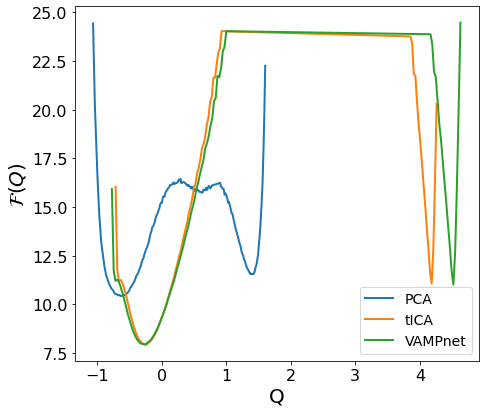

In [55]:
fig, ax = plt.subplots(1,1)


def free_energy_estimate(samples, beta, minimum_counts=50, bins=200):
    # histogram
    counts, coordinate = np.histogram(samples, bins=bins)
    robust_counts = counts[np.where(counts > minimum_counts)]
    robust_coordinates = coordinate[np.where(counts > minimum_counts)]

    # log normal
    normalised_counts = robust_counts / np.sum(counts)
    with np.errstate(divide='ignore'):
        free_energy = - (1 / beta) * np.log(normalised_counts)

    return free_energy, robust_coordinates


y, x = free_energy_estimate(alanine_exp_1us.PCA.get_output()[0][:,0], beta=1/2.479, minimum_counts=50)
ax.plot(x, y, label='PCA')

y, x = free_energy_estimate(alanine_exp_1us.TICA.get_output()[0][:,0], beta=1/2.479, minimum_counts=50)
ax.plot(x, y, label='tICA')

y, x = free_energy_estimate(alanine_exp_1us.VAMP.get_output()[0][:,0], beta=1/2.479, minimum_counts=50)
ax.plot(x, y, label='VAMPnet')

DMAP_traj = dill.load(open('/home/dominic/PycharmProjects/mdfeature/data/outputs/alanine_1us/alanine_exp_1us_s2_dm.pickle', "rb"))
#y, x = free_energy_estimate(DMAP_traj.DMAP.dmap[:,0], beta=1, minimum_counts=1, bins=100)
#ax[1].hist(DMAP_traj.DMAP.dmap[:,0],label='Diffusion maps', bins=200)

A = DMAP_traj.DMAP.dmap[:,0]
B = A[A > -1000]
C = A[A < -1000]
print(len(B), len(C))
print(np.mean(B),np.mean(C))
print(np.std(B), np.std(C))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('Q', fontsize=20)
ax.set_ylabel(r'$\mathcal{F}(Q)$', fontsize=20)
ax.legend(fontsize=14)


ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

#ax[1].set_xlabel('Q', fontsize=20)
#ax[1].set_ylabel(r'$\mathcal{F}(Q)$', fontsize=20)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].legend(fontsize=14)

fig.set_size_inches(7,6)

#plt.hist(DMAP_traj.DMAP.dmap[:,0], bins=300)
#plt.axis('log')

plt.savefig("free_energy_comparison_alanine.pdf")

/home/dominic/PycharmProjects/mdfeature/src/mdfeature/KramersRateEvaluator.py:33: UserWarning: NaN values were found in the free energy calculation. Consider using a longer trajectory or rerunning with fewer bins (currently bins=200). Fixing with imputation for now.
  warnings.warn(f"NaN values were found in the free energy calculation. "


Note: Of the 200 free energy evaluations, 33 were NaN values.
Using default clustering provided.


estimating MaximumLikelihoodMSM:   0%|                                                                        …

2.0 fs <class 'openmm.unit.quantity.Quantity'>
[0.0205355  0.01914242 0.01844294 0.01770668 0.01718296 0.01655115
 0.0158865  0.01577614 0.01498954 0.01488667 0.01451446 0.01426519
 0.0142192  0.01399389 0.01406548 0.0137202  0.01370205 0.01365911
 0.0135482  0.01329513 0.01348361 0.01343063 0.01347393 0.01389261
 0.01380763 0.01377654 0.01427178 0.01429416 0.01461063 0.01473892
 0.01491649 0.01499041 0.01497299 0.01519678 0.0152376  0.01524105
 0.01539738 0.01531836 0.01566082 0.01588594 0.01584546 0.01570511
 0.01582045 0.01549765 0.01572475 0.01575961 0.01545269 0.01571425
 0.01551062 0.01547233 0.01551764 0.01532375 0.01523792 0.01541997
 0.0154571  0.01557912 0.01553534 0.01551906 0.01566612 0.01561146
 0.0158758  0.01568199 0.01591935 0.01608712 0.01671772 0.01682576
 0.01683435 0.01678053 0.01709699 0.01705892 0.01758034 0.01823114
 0.01803504 0.01821846 0.01847008 0.01889408 0.01773347 0.03171707
 0.2350501  0.02205249 0.01133715 0.01037495 0.00988342 0.00814366
 0.00818925 0.0

100.0 fs <class 'openmm.unit.quantity.Quantity'>
[0.0003285  0.00032332 0.00032356 0.00032918 0.00032577 0.00032446
 0.00033172 0.00032298 0.00032788 0.00032857 0.00032899 0.00032953
 0.00032436 0.00033291 0.00032752 0.00032736 0.00033006 0.00032887
 0.00032402 0.00032911 0.00032243 0.00032709 0.00032135 0.00032824
 0.00032583 0.0003273  0.00032498 0.00032975 0.00033064 0.00032919
 0.00032754 0.00032856 0.00032426 0.00032565 0.00032262 0.00032454
 0.00033243 0.00032641 0.00032766 0.00032424 0.00032858 0.00032626
 0.00032566 0.00032429 0.00032433 0.0003275  0.00032641 0.00032429
 0.00032682 0.00032855 0.00032907 0.00032847 0.00032625 0.00032668
 0.000328   0.00032468 0.00032432 0.00032627 0.00032465 0.00032995
 0.00032308 0.00032338 0.00032194 0.0003191  0.00032386 0.00032579
 0.0003335  0.00031798 0.00032337 0.00032718 0.00033129 0.00033081
 0.00032982 0.00033732 0.00032075 0.0003184  0.00032288 0.00060083
 0.00511945 0.00048734 0.00013847 0.00013444 0.00019512 0.0001528
 0.00014962 0.

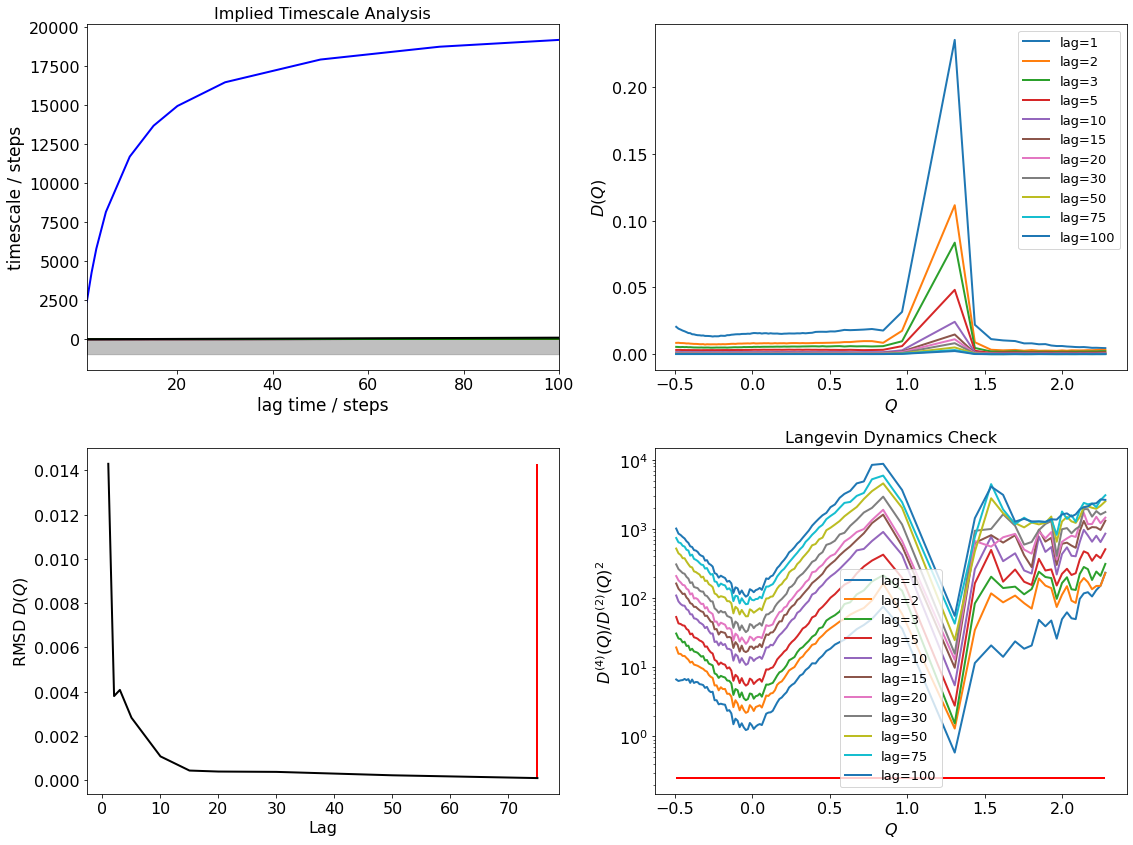

30.0 fs <class 'openmm.unit.quantity.Quantity'>
[0.00107374 0.00106396 0.00108066 0.00109033 0.00107247 0.00107922
 0.00108765 0.00108105 0.00110111 0.00108279 0.00107318 0.00108275
 0.00107271 0.0010715  0.00107629 0.00107038 0.00108075 0.00106607
 0.00108013 0.00107817 0.00106926 0.00106107 0.00108881 0.00108185
 0.00107575 0.00107753 0.00108428 0.00109061 0.00107295 0.00106931
 0.00107616 0.00109411 0.00109921 0.00107737 0.00110247 0.0010746
 0.00108069 0.00111047 0.00108974 0.00108348 0.00108129 0.00110607
 0.00107916 0.00109284 0.00108222 0.00108664 0.00109677 0.00107505
 0.00108466 0.00110467 0.00109952 0.00108746 0.00110751 0.00106056
 0.00109344 0.00110147 0.00108627 0.00108158 0.00107995 0.00110721
 0.00109227 0.00109017 0.00108937 0.00109261 0.00108108 0.00111588
 0.00111192 0.00108807 0.00108146 0.00108682 0.00107098 0.001076
 0.00106954 0.00106597 0.00103604 0.00099062 0.0009911  0.002071
 0.01479458 0.00077075 0.00046722 0.00040013 0.00043624 0.00044363
 0.00057327 0.00043

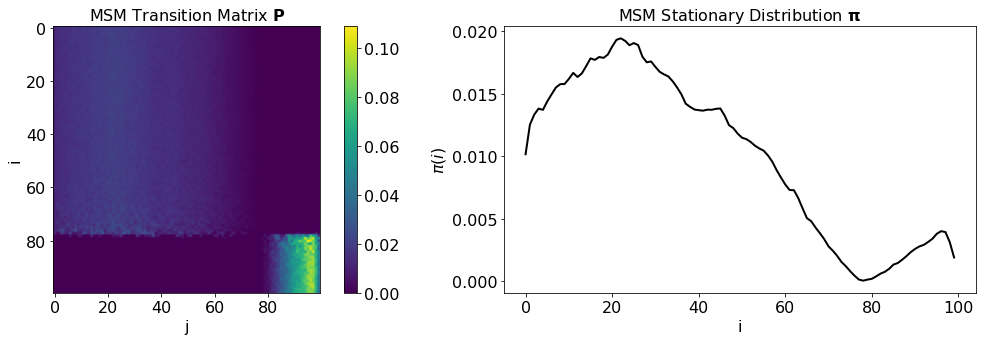

KeyboardInterrupt: 

In [7]:
alanine_exp_1us.analyse_TICA(dimension=1, lag=15, sigmaD=0.5, sigmaF=0.05)

In [6]:
dill.dump(alanine_exp_1us, file=open("alanine_exp_1us_s2_dm.pickle", "wb"))

28 NaNs detected, removing rows with NaNs.


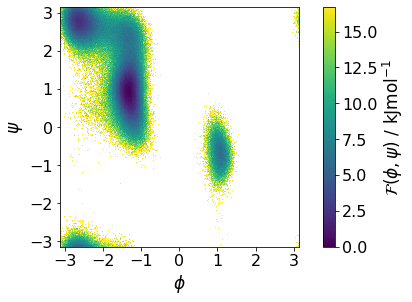

NameError: name 'pd' is not defined

In [100]:
reference_free_energy = alanine_exp_1us.ramachandran_plot(rotate=False, bins=300, save_fig=True, save_name='1us_rp_unbiased.pdf')
print(f"Ramachandran plot grid dimension: {reference_free_energy.shape}")

In [10]:
alanine_exp_20ns.compute_DMAP(stride=1)
alanine_exp_1us.compute_DMAP(stride=5)

Computed DMAP in 1797.133s.
Computed DMAP in 2514.815s.


In [11]:
dill.dump(alanine_exp_20ns, file=open("alanine_exp_20ns.pickle", "wb"))
dill.dump(alanine_exp_1us, file=open("alanine_exp_1us.pickle", "wb"))

In [17]:
print(len(alanine_exp_1us.DMAP.dmap))

197408


In [4]:
class Dihedral:
    
    def __init__(self, atom_indices, residue_indices, sincos, offset, idx: int):
        self.atom_indices = atom_indices
        self.residue_indices = residue_indices
        self.sincos = sincos
        self.offset = offset
        self.idx = idx
        #self.str_index = str(int(np.floor(self.idx/2)))
        self.dihedral_label_trig_removed = "_".join([str(s+1) for s in atom_indices])
        self.dihedral_label = str(self.sincos)+"_"+self.dihedral_label_trig_removed
    
    def torsion_label(self):
        # plumed is 1 indexed and mdtraj is not
        if self.sincos == "sin": #only output one torsion label per sin-cos pair
            return "TORSION ATOMS="+",".join(str(i+1) for i in self.atom_indices)+F" LABEL={self.dihedral_label_trig_removed} \\n\\"
        else:
            return None
    
    def transformer_label(self):
        return f"MATHEVAL ARG={self.dihedral_label_trig_removed} FUNC={self.sincos}(x)-{self.offset} LABEL={self.dihedral_label} PERIODIC=NO \\n\\"
        
        

class Dihedrals:
    
    def __init__(self, dihedrals: DihedralFeature, offsets: list[float], coefficients: list[float]):
        # TODO: init with coefficients 
        self.dihedral_list = []
        self.dihedral_labels = []
        self.coefficients = [str(v) for v in coefficients]
        self.initialise_lists(dihedrals[0], offsets)
            
    def parse_dihedral_string(self, txt: str):
        num_seq = np.array([int(s) for s in re.findall(r'\b\d+\b', txt)])
        if "SIN" in txt and "COS" not in txt:
            sincos = "sin"
        elif "COS" in txt and "SIN" not in txt:
            sincos = "cos"
        else:
            raise ValueError(f"Expected either SIN or COS in string, got {txt}.")
        atom_indices =  num_seq[1::2] 
        residue_indices = num_seq[0::2]
        return atom_indices, residue_indices, sincos
    
    def initialise_lists(self, dihedrals, offsets):
        dihedral_labels = dihedrals.describe()
        assert len(dihedral_labels) == len(offsets), "The number of offets must equal the number of dihedrals."
        for idx, label in enumerate(dihedral_labels):
            atom_indices, residue_indices, sincos = self.parse_dihedral_string(label)
            dihedral = Dihedral(atom_indices, residue_indices, sincos, offsets[idx], idx)
            self.dihedral_list.append(dihedral)
            self.dihedral_labels.append(dihedral.dihedral_label)
            
    def write_torsion_labels(self, file):
        for dihedral in self.dihedral_list:
            output = dihedral.torsion_label() 
            if output is not None:
                print(output)
                file.writelines(output+'\n')
            
    def write_transform_labels(self, file):
        for dihedral in self.dihedral_list:
            output = dihedral.transformer_label() 
            print(output)
            file.writelines(output+'\n')
            
    def write_combined_label(self, CV, file):
        output = f"COMBINE LABEL={CV}_0"+f" ARG={','.join(self.dihedral_labels)}" + f" COEFFICIENTS={','.join(self.coefficients)}" + " PERIODIC=NO" + " \\n\\" 
        print(output)
        file.writelines(output+'\n')

estimating MaximumLikelihoodMSM:   0%|                                                                        …

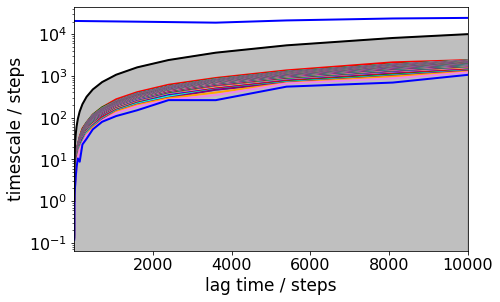

In [707]:
alanine_exp_1us.implied_timescale_analysis(max_lag=10000, k=100)

Computed TICA in 0.16s.
Computed TICA in 0.139s.
Computed TICA in 0.141s.
Computed TICA in 0.138s.
Computed TICA in 0.138s.
Computed TICA in 0.134s.
Computed TICA in 0.147s.
Computed TICA in 0.143s.
Computed TICA in 0.137s.
Computed TICA in 0.139s.
Computed TICA in 0.143s.
Computed TICA in 0.13s.
Computed TICA in 0.136s.
Computed TICA in 0.135s.


/tmp/ipykernel_5968/2906940858.py:15: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=2)


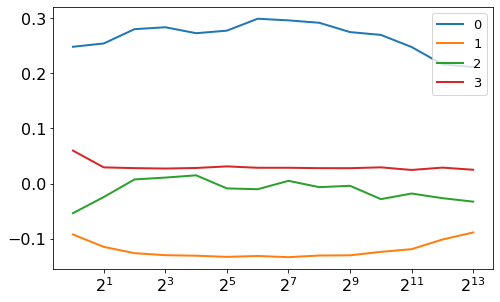

In [727]:
eig0=[]
eig1=[]
eig2=[]
eig3=[]
eig4=[]
lags = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
for lag in lags:
    alanine_exp_1us.compute_TICA(lag=lag, dim=1)
    eig = alanine_exp_1us.eigenvector('TICA', dim=0)
    eig0.append(eig[4])
    eig1.append(eig[5])
    eig2.append(eig[6])
    eig3.append(eig[7])
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
ax.plot(lags, eig0, label='0')
ax.plot(lags, eig1, label='1')
ax.plot(lags, eig2, label='2')
ax.plot(lags, eig3, label='3')
ax.legend()

In [731]:
#alanine_exp_1us.compute_DMAP(stride=1000)
alanine_exp_1us.create_plumed_metadynamics_script(CV='PCA')

plumed_script="RESTART \n\
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 \n\
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 \n\
TORSION ATOMS=2,5,7,9 LABEL=2_5_7_9 \n\
TORSION ATOMS=9,15,17,19 LABEL=9_15_17_19 \n\
MATHEVAL ARG=5_7_9_15 FUNC=cos(x)--0.018100298941135406 LABEL=cos_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=5_7_9_15 FUNC=sin(x)--0.7750170826911926 LABEL=sin_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=cos(x)-0.11455978453159332 LABEL=cos_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=sin(x)-0.5776147246360779 LABEL=sin_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=cos(x)--0.9876720905303955 LABEL=cos_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=sin(x)--0.0018686018884181976 LABEL=sin_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=cos(x)--0.9883973598480225 LABEL=cos_9_15_17_19 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=sin(x)--0.004300905857235193 LABEL=sin_9_15_17_19 PERIODIC=NO \n\
COMBINE LABEL=PCA_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_

In [634]:
alanine_exp_1us.fluctuations_features

array([0.48558477, 0.40551752, 0.7119853 , 0.38256413], dtype=float32)

In [651]:
vamp_md = Experiment('../CSD3scripts/outputs/production_alanine_amber_175730_160722/', 'alanine_1.5ns_VAMP_dihedral_traj.pickle', 300, '1.5ns', '1ps', '2fs', default_torsions = [phi, psi, zeta, theta])

Successfully loaded experiment data.
Successfully initialised experiment metadata.
Successfully featurized trajectory.


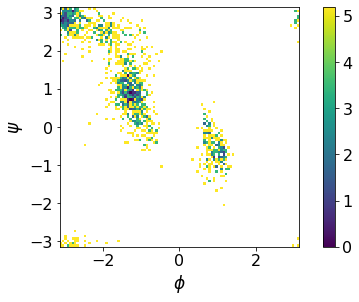

In [652]:
vamp_md.ramachandran_plot(rotate=True)

## Collective Variable Error Estimates

## Convergence Rate Comparisons

In [30]:
temperature = 300
duration = "350ns" 
savefreq = "1ps"
stepsize = "2fs"
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]
default_torsions = [phi, psi, zeta, theta]
dihedrals = [phi, psi]


location = '../CSD3scripts/long_experiments/production_alanine_amber_350ns_ref'
exp_long_ref = Experiment(location = location, 
                      temperature = temperature,
                      duration = duration,
                      savefreq = savefreq,
                      stepsize = stepsize,
                      default_torsions = default_torsions,
                      dihedrals = dihedrals,
                      #dihedral_pickle_file = 'alanine_40ns_tICA_orig_dihedral_traj.pickle',
                      metad_bias_file = '/home/dominic/PycharmProjects/mdfeature/CSD3scripts/long_experiments/production_alanine_amber_350ns_ref/COLVAR_REF_REWEIGHT'
                      )


# location = '../data/outputs/PCA1'
# exp_pca1 = Experiment(location = location, 
#                       temperature = temperature,
#                       duration = duration,
#                       savefreq = savefreq,
#                       stepsize = stepsize,
#                       default_torsions = default_torsions,
#                       dihedrals = dihedrals)


Successfully initialised experiment metadata.
Running dihedral trajectory analysis.


/home/dominic/PycharmProjects/mdfeature/src/mdfeature/analine_free_energy.py:48: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cos_theta) * np.sign(np.dot(rkj, np.cross(t, u)))
/home/dominic/PycharmProjects/mdfeature/src/mdfeature/analine_free_energy.py:48: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cos_theta) * np.sign(np.dot(rkj, np.cross(t, u)))


Finished dihedral trajectory analysis.
Successfully loaded experiment data.
Successfully featurized trajectory.


In [32]:
def deg_to_rad(deg):
    return (deg/180)*np.pi

list_deg = [-84.6, 73.0, -165.7, 167.3, 74.6, -62.0, -134.2, 38.1, -91.9, -5.5, 60.8, 40.6]

for deg in list_deg:
    print(deg_to_rad(deg))

-1.4765485471872026
1.2740903539558606
-2.8920105705546035
2.9199358385865133
1.3020156219877697
-1.0821041362364843
-2.34223185617639
0.6649704450098396
-1.6039575825827888
-0.09599310885968812
1.0611601852125523
0.7086036763096978


In [279]:
temperature = 300
duration = "20ns" 
savefreq = "1ps"
stepsize = "2fs"
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]
default_torsions = [phi, psi, zeta, theta]
dihedrals = [phi, psi]
location = '../CSD3scripts/outputs/production_alanine_amber_162613_100822'
exp_TICA1 = Experiment(location = location, 
                      temperature = temperature,
                      duration = duration,
                      savefreq = savefreq,
                      stepsize = stepsize,
                      default_torsions = default_torsions,
                      dihedrals = dihedrals,
                      #dihedral_pickle_file = 'alanine_40ns_tICA_orig_dihedral_traj.pickle',
                      metad_bias_file = '/home/dominic/PycharmProjects/mdfeature/CSD3scripts/long_experiments/COLVAR_TICAMD_REWEIGHT'
                      )

Successfully initialised experiment metadata.
Running dihedral trajectory analysis.


/home/dominic/PycharmProjects/mdfeature/src/mdfeature/analine_free_energy.py:48: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cos_theta) * np.sign(np.dot(rkj, np.cross(t, u)))


Finished dihedral trajectory analysis.
Successfully loaded experiment data.
Successfully featurized trajectory.


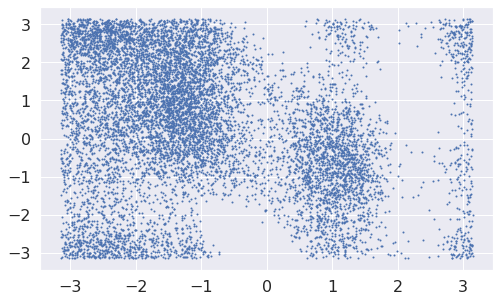

In [218]:
N = 10000
x = exp_long_ref.dihedral_traj[:N,:][:,0]
y = exp_long_ref.dihedral_traj[:N,:][:,1]
plt.scatter(x,y,s=1)

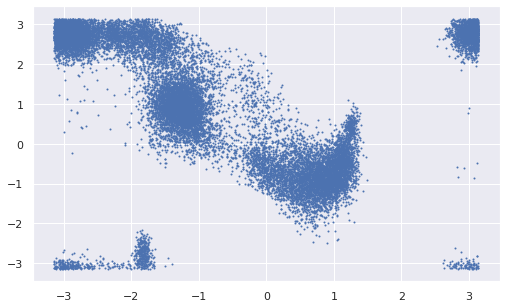

In [275]:
N = 100000
x = exp_TICA1.dihedral_traj[:N,:][:,0]
y = exp_TICA1.dihedral_traj[:N,:][:,1]
plt.scatter(x,y,s=1)

3 NaNs detected, removing rows with NaNs.
0.0 35.509183


(array([-2.72222447, -2.55942345, -2.82146406, ..., -1.80853617,
        -1.80665994, -1.2901088 ]),
 array([ 2.82354712,  2.9594202 ,  2.5710299 , ..., -2.94521737,
         2.22323751,  1.10425448]),
 array([-75.739941, -77.647978, -68.376867, ..., -71.810407, -65.890812,
        -43.208105]))

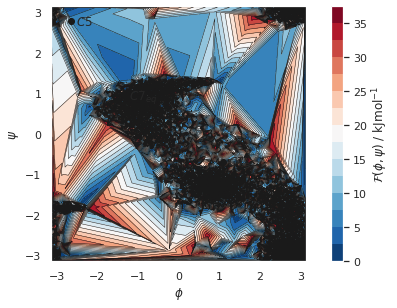

In [301]:
points_of_interest = [(r"$C7_{eq}$", -1.35,0.96),(r"$C5$",-2.64,2.79),(r"$C7_{ax}$",1.09,-0.70)]#, (r"$\ddag$",0.01,-0.64)]

def ramachandran_from_x_y_z(x, y, z, rotate, levels=None):
    fig, ax = plt.subplots()
    if rotate is True:
        cntr2 = ax.tricontourf(y, x, z, levels=levels, cmap="RdBu_r")
        ax.tricontour(y, x, z, levels=levels, linewidths=0.5, colors='k')
    else:
        cntr2 = ax.tricontourf(x, y, z, levels=levels, cmap="RdBu_r")
        ax.tricontour(x, y, z, levels=levels, linewidths=0.5, colors='k')
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$\psi$')
    plt.gca().set_aspect('equal')
    cbar = fig.colorbar(cntr2, ax=ax)
    cbar.set_label(r'$\mathcal{F}(\phi,\psi)$ / kJmol$^{-1}$')
    ax.set(xlim=(-np.pi, np.pi), ylim=(-np.pi, np.pi))
    plt.xticks(np.arange(-3, 4, 1))
    plt.subplots_adjust(hspace=0.5)
    

def ramachandran(exp, points_of_interest, rotate=True, save_name=None):
    xyz = check_and_remove_nans(np.hstack([exp.dihedral_traj, np.array([exp.bias_potential_traj]).T]))
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    fe = -z + np.max(z)
    print(np.min(fe),np.max(fe))
    #set level increment every unit of kT
    num_levels = int(np.floor((np.max(fe)-np.min(fe)) / 2.5))
    levels = [k * 2.5 for k in range(num_levels+2)]
    ramachandran_from_x_y_z(x, y, fe, rotate, levels)
    for point in points_of_interest:
        plt.text(s=point[0],x=point[1]+0.12,y=point[2]-0.1)
        plt.scatter(point[1],point[2],c='k')
    #plt.savefig(save_name, format="pdf", bbox_inches="tight")
    return x, y, -z
    
def ramachandran2(exp, points_of_interest, rotate=True, save_name=None, nan_threshold=50, low_threshold=0, data_fraction=1, bins=300):
    dihedral_traj = check_and_remove_nans(exp.dihedral_traj)
    final_iteration = int(data_fraction * len(dihedral_traj))
    free_energy, xedges, yedges = free_energy_estimate_2D(dihedral_traj[:final_iteration], exp.beta, bins=bins, weights=exp._slice(exp.metad_weights,final_iteration)/max(exp.metad_weights))
    fig, ax = plt.subplots()
    if rotate is True:
        free_energy = free_energy.T
    if low_threshold is None:
        masked_free_energy = np.ma.array(free_energy, mask=(free_energy > nan_threshold))
    else:
        masked_free_energy = np.ma.array(free_energy, mask=(np.logical_or((free_energy > nan_threshold),(free_energy < low_threshold))))
    im = ax.pcolormesh(xedges, yedges, masked_free_energy)
    cbar = plt.colorbar(im)
    cbar.set_label(r'$\mathcal{F}(\phi,\psi)$ / kJmol$^{-1}$')
    plt.xticks(np.arange(-3, 4, 1))
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$\psi$')
    plt.gca().set_aspect('equal')
    for point in points_of_interest:
        plt.text(s=point[0],x=point[1]+0.12,y=point[2]-0.1)
        plt.scatter(point[1],point[2],c='k')
    plt.savefig(save_name, format="pdf", bbox_inches="tight")

#exp_TICA1.flip_dihedral_coords()
#x, y, z = ramachandran(exp_long_ref, points_of_interest, rotate=False, save_name='350ns_FES_AD')
ramachandran(exp_TICA1, points_of_interest, rotate=True, save_name='ticaMD.pdf')
#ramachandran2(alanine_exp_1us, points_of_interest, rotate=False, save_name='unbiased_ref_1us_FES.pdf')

## Interpolate Grid Data and Calculate Convergence Rates

(19999, 2)
(19999, 2)
23 NaNs detected, removing rows with NaNs.
3 NaNs detected, removing rows with NaNs.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.10it/s]


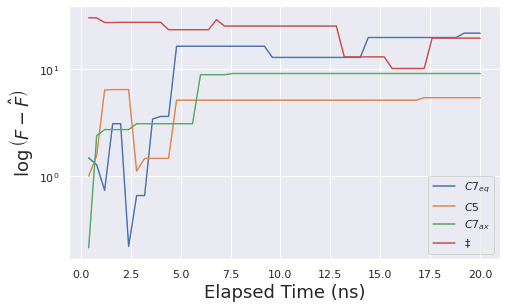

In [277]:
import scipy
import seaborn as sns
from tqdm import tqdm
sns.color_palette("pastel")
sns.set()

def get_mean_and_variance(list_of_arrays):
    mean_array = np.zeros(list_of_arrays[0].shape)
    std_array = np.zeros(list_of_arrays[0].shape)
    num_arrs = len(list_of_arrays)
    for arr in list_of_arrays:
        mean_array += arr
    mean_array /= num_arrs
    
    for arr in list_of_arrays:
        std_array += arr**2
    std_array /= num_arrs
    std_array -= mean_array**2
    std_array = np.sqrt(std_array)
    
    return mean_array, std_array

def get_x_y_z_fe(exp):
    xyz = check_and_remove_nans(np.hstack([exp.dihedral_traj, np.array([exp.bias_potential_traj]).T]))
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    fe = -z + np.max(z)
    return x, y, z, fe

def get_mean_and_variance_fe_traj(exps, data_fraction, interpolation_method, number_of_points):
    combined_fe_traj = []
    for exp in exps:
        x, y, z, fe = get_x_y_z_fe(exp)

        # Get time intervals for plot
        time_intervals = [int(data_fraction * (point_number+1) * len(fe)/number_of_points) for point_number in range(number_of_points)]

        # Compute free energy deviations for each time interval
        free_energy_trajectory = []
        for time in tqdm(time_intervals):
            interpolated_points = scipy.interpolate.griddata(points=(x[:time],y[:time]), values=fe[:time], xi=critical_points, method=interpolation_method)
            free_energy_trajectory.append(interpolated_points)
        combined_fe_traj.append(np.array(free_energy_trajectory))
    combined_fe_traj = np.array(combined_fe_traj)
    
    mean_fe_traj, std_fe_traj = get_mean_and_variance(combined_fe_traj)
    return mean_fe_traj, std_fe_traj, time_intervals

def convergence_of_critical_points(mean_fe_traj, std_fe_traj, critial_points, critical_point_labels, ref_fe, time_intervals):
    for point_idx in range(len(critical_points)):
        fe_traj_crit_point = np.abs(mean_fe_traj[:,point_idx] - ref_fe[point_idx])
        plt.plot(np.array(time_intervals)/1000, fe_traj_crit_point, label=critical_point_labels[point_idx])
        plt.fill_between(np.array(time_intervals)/1000, fe_traj_crit_point-std_fe_traj[:,point_idx],fe_traj_crit_point+std_fe_traj[:,point_idx])
    plt.xlabel('Elapsed Time (ns)', fontsize=18)
    plt.ylabel(r'$\log\left(F-\hat{F}\right)$', fontsize=18)
    plt.yscale('log')
    plt.legend()
    plt.show()
        

def plot_convergence(exps, reference_exp, points_of_interest, number_of_points=5, interpolation_method='linear', data_fraction=1):
    for exp in exps:
        assert exp.savefreq == reference_exp.savefreq
    
    x_r, y_r, z_r, fe_r = get_x_y_z_fe(reference_exp)
    
    critical_point_labels = [point[0] for point in points_of_interest]
    critical_points = [[point[1], point[2]] for point in points_of_interest]
    
    ref_fe = scipy.interpolate.griddata(points=(x_r,y_r), values=fe_r, xi=critical_points, method=interpolation_method)
    
    mean_fe_traj, std_fe_traj, time_intervals = get_mean_and_variance_fe_traj(exps, data_fraction, interpolation_method, number_of_points)
        
    convergence_of_critical_points(mean_fe_traj, std_fe_traj, critical_points, critical_point_labels, ref_fe, time_intervals)

exp_TICA1.flip_dihedral_coords()
points_of_interest = [(r"$C7_{eq}$", -1.35,0.96),(r"$C5$",-2.64,2.79),(r"$C7_{ax}$",1.09,-0.70), (r"$\ddag$",0.01,-0.64)]    
plot_convergence([exp_TICA1], exp_long_ref, points_of_interest, number_of_points=50, data_fraction=1, interpolation_method='linear')


7 NaNs detected, removing rows with NaNs.
[3.19476223e+17 7.71938347e+17 6.42711665e+17 ... 3.34736118e+17
 1.34360821e+11 6.24850460e+16]


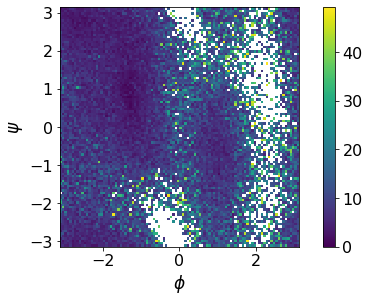

masked_array(
  data=[[6.081801724003501, 6.845800864187428, 4.069761281316282, ...,
         7.637889358269707, 3.4498866436595783, 6.158796647052434],
        [5.565363998733705, 4.5433246062054415, 6.471674999417367, ...,
         7.057676849141039, 9.6627244338505, 12.631890193928811],
        [7.815673608019374, 2.973480750424585, 5.796673901258764, ...,
         5.741722373175133, 5.241346332829508, 7.745959699607571],
        ...,
        [4.742873210702559, 4.04426124703437, 3.1324198034154875, ...,
         6.701487190445807, 7.262165029609346, 11.1405672951641],
        [3.614255833680666, 2.7735469108443027, 5.561834140976583, ...,
         7.099145369156222, 5.403787659981614, 3.8879924221054623],
        [1.6624915055951597, 3.7494899183776056, 3.224881931734778, ...,
         6.3954103845306385, 4.308466925472672, 3.8964636147116813]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, F

In [46]:
exp_orig_tica1.ramachandran_plot(data_fraction=1, rotate=True, nan_threshold=50, low_threshold=0)

In [29]:
exp_pca2.ramachandran_plot()

NameError: name 'exp_pca2' is not defined

5 NaNs detected, removing rows with NaNs.


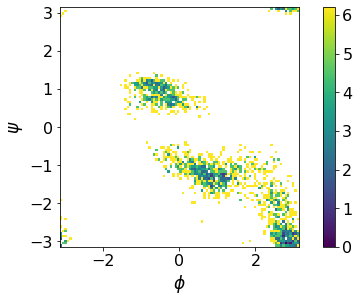

masked_array(
  data=[[2.183715490357434, --, --, ..., 2.7403110701865447,
         2.183715490357434, 6.198198643939424],
        [--, 4.469254857686256, 4.469254857686256, ...,
         2.7403110701865447, 3.457887576245966, 2.7403110701865447],
        [--, --, 3.457887576245966, ..., 1.0113672820635617,
         4.469254857686256, 1.7289437883307421],
        ...,
        [--, 6.198198643939424, --, ..., --, --, --],
        [--, --, 6.198198643939424, ..., 6.198198643939424,
         6.198198643939424, 4.469254857686256],
        [--, --, --, ..., 3.457887576245966, 4.469254857686256,
         6.198198643939424]],
  mask=[[False,  True,  True, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        ...,
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+2

In [167]:
exp_tica1.ramachandran_plot(0.05)

2 NaNs detected, removing rows with NaNs.


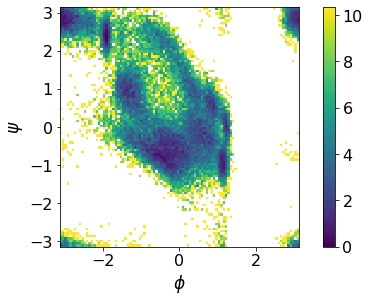

In [32]:
exp_vamp1.ramachandran_plot()

In [33]:
from scipy.optimize import brute as brute_minimizer

[-1.38230163  0.96342022] [4.33644483e-05]
[-2.61798946  2.78561508] [1.96693026]
[ 1.13097413 -0.77492967] [5.54369196]


/tmp/ipykernel_68968/3593646253.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ref.x_values(), ref.y_values(), reference_free_energy)


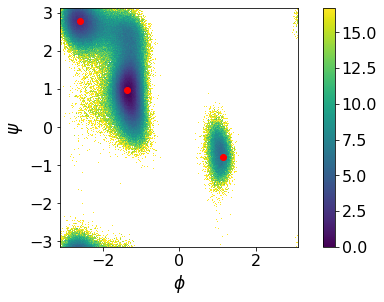

In [52]:
ref = AreaOfInterest(x_min=-np.pi, x_max=np.pi, y_min=-np.pi, y_max=np.pi, values=reference_free_energy)

# cubic interpolation on grid
interp_ref = interpolate.interp2d(ref.x_values(), ref.y_values(), ref.values, kind='linear')
def split_wrapper(z):
    x, y = z
    return interp_ref(x,y)

minimum1 = brute_minimizer(split_wrapper, (slice(-1.5, -1.2, 0.01), slice(0.75, 1.25, 0.01)))
print(minimum1, split_wrapper(minimum1))


minimum2 = brute_minimizer(split_wrapper, (slice(-2.9, -2.3, 0.01), slice(2.3, 3, 0.01)))
print(minimum2, split_wrapper(minimum2))


minimum3 = brute_minimizer(split_wrapper, (slice(0.5, 1.75, 0.01), slice(-2, 0.75, 0.01)))
print(minimum3, split_wrapper(minimum3))

fig, ax = plt.subplots()
im = ax.pcolormesh(ref.x_values(), ref.y_values(), reference_free_energy)
plt.colorbar(im)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')
plt.gca().set_aspect('equal')
plt.scatter(*minimum1, c='r')
plt.scatter(*minimum2, c='r')
plt.scatter(*minimum3, c='r')
plt.show()

In [133]:
from itertools import combinations
from tqdm import tqdm

class ConvergenceAnalyser:

    def __init__(self, min1, min2, min3, trajectory, beta):
        self.min1 = min1
        self.min2 = min2
        self.min3 = min3
        self.beta = beta
        self.trajectory = check_and_remove_nans(trajectory)

    def plot_anomaly(self, burn_in=1000, plot_interval=20000, sigma=None):
        steps = []
        min21 = []
        min31 = []
        min32 = []
        min1 = []
        min2 = []
        min3 = []
        domain_rmsd_anomalies = []
        for step in tqdm(np.arange(plot_interval, len(self.trajectory), plot_interval)):
            if step > burn_in:
                free_energy, x_edges, y_edges = free_energy_estimate_2D(self.trajectory[:step], beta=self.beta, bins=300)
                fig, ax = plt.subplots()
                masked_free_energy = np.ma.array(free_energy, mask=(free_energy > 50))
                im = ax.pcolormesh(x_edges, y_edges, masked_free_energy)
                plt.colorbar(im)
                plt.xlabel(r'$\phi$')
                plt.ylabel(r'$\psi$')
                plt.gca().set_aspect('equal')
                plt.show()
                input()
                #print(x_edges)
                interp_ref = interpolate.interp2d(x_edges[:-1], y_edges[:-1], free_energy, kind='linear')

                # minima 2 - minima 1 difference
                min21.append(interp_ref(self.min2[0], self.min2[1])-interp_ref(self.min1[0],self.min1[1]))

                # minima 3 - minima 1 difference
                min31.append(interp_ref(self.min3[0], self.min3[1])-interp_ref(self.min1[0],self.min1[1]))

                # minima 3 - minima 2 difference
                min32.append(interp_ref(self.min3[0], self.min3[1])-interp_ref(self.min2[0],self.min2[1]))
                
                min1_val = interp_ref(self.min1[0], self.min1[1])
                min2_val = interp_ref(self.min2[0], self.min2[1])
                min1.append(min1_val)
                min2.append(min2_val)
                min3.append(interp_ref(self.min3[0], self.min3[1]))
                
                steps.append(step)
            
        plt.plot(steps, min1, c='k')
        plt.semilogy()
        plt.xlim([0, len(self.trajectory)])
        plt.xlabel('Steps Elapsed')
        plt.ylabel(r'$\hat{F}_{1}$')
        plt.hlines(0, 0, max(steps), colors='r')
        plt.show()

        plt.plot(steps, min2, c='k')
        plt.xlim([0, len(self.trajectory)])
        plt.xlabel('Steps Elapsed')
        plt.ylabel(r'$\hat{F}_{2}$')
        plt.hlines(1.96693026, 0, max(steps), colors='r')
        plt.show()
        
        plt.plot(steps, min3, c='k')
        plt.xlim([0, len(self.trajectory)])
        plt.xlabel('Steps Elapsed')
        plt.ylabel(r'$\hat{F}_{3}$')
        plt.hlines(5.54369196, 0, max(steps), colors='r')
        plt.show()

        plt.plot(steps, min21, c='k')
        plt.semilogy()
        plt.xlim([0, len(self.trajectory)])
        plt.xlabel('Steps Elapsed')
        plt.ylabel(r'$\vert{\Delta \hat{F}}_{2} - \Delta \hat{F}_{1}\vert$')
        plt.hlines(1.96693026, 0, max(steps), colors='r')
        plt.show()

        plt.plot(steps, min31, c='k')
        plt.xlim([0, len(self.trajectory)])
        plt.xlabel('Steps Elapsed')
        plt.ylabel(r'$\vert{\Delta \hat{F}}_{3} - \Delta \hat{F}_{1}\vert$')
        plt.hlines(5.54369, 0, max(steps), colors='r')
        plt.show()
        
        plt.plot(steps, min32, c='k')
        plt.xlim([0, len(self.trajectory)])
        plt.xlabel('Steps Elapsed')
        plt.ylabel(r'$\vert{\Delta \hat{F}}_{3} - \Delta \hat{F}_{2}\vert$')
        plt.hlines(5.54369-1.96692, 0, max(steps), colors='r')
        plt.show()

28 NaNs detected, removing rows with NaNs.


  0%|                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

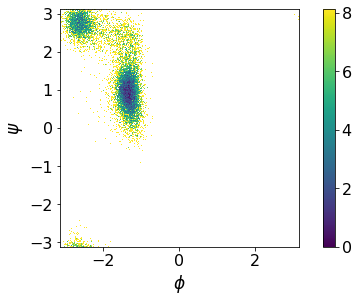

  2%|██▉                                                                                                                                            | 1/49 [00:25<20:18, 25.39s/it]

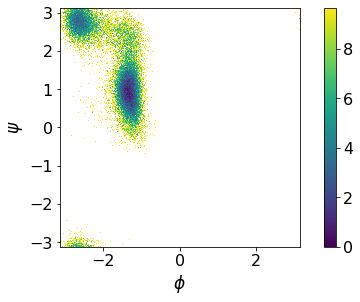

  4%|█████▊                                                                                                                                         | 2/49 [00:26<08:30, 10.86s/it]

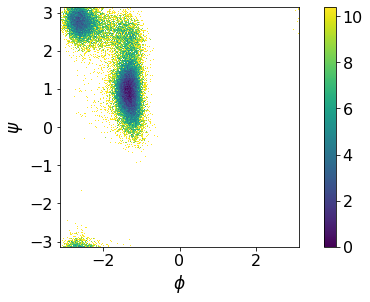

  6%|████████▊                                                                                                                                      | 3/49 [00:26<04:46,  6.23s/it]

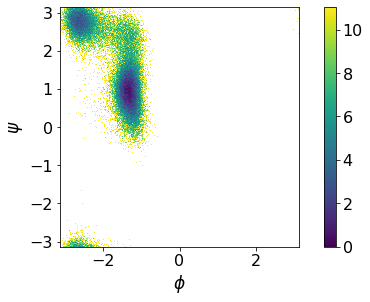

  8%|███████████▋                                                                                                                                   | 4/49 [00:27<03:02,  4.05s/it]

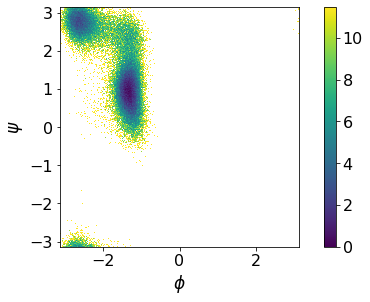

 10%|██████████████▌                                                                                                                                | 5/49 [00:28<02:03,  2.82s/it]

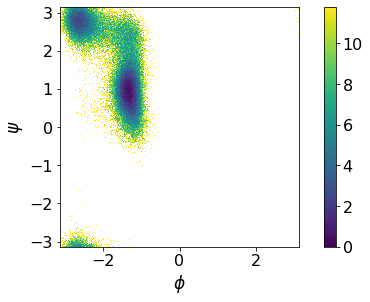

 12%|█████████████████▌                                                                                                                             | 6/49 [00:28<01:28,  2.06s/it]

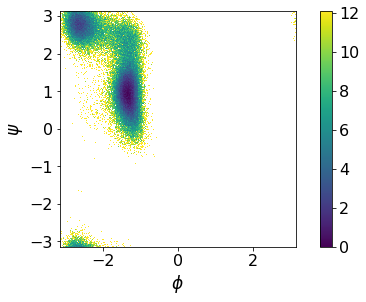

 14%|████████████████████▍                                                                                                                          | 7/49 [00:29<01:06,  1.59s/it]

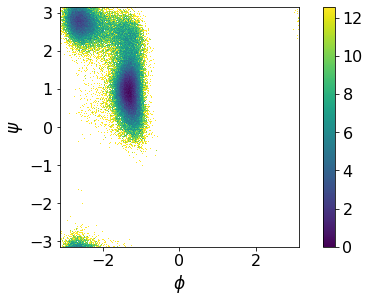

 16%|███████████████████████▎                                                                                                                       | 8/49 [00:29<00:51,  1.26s/it]

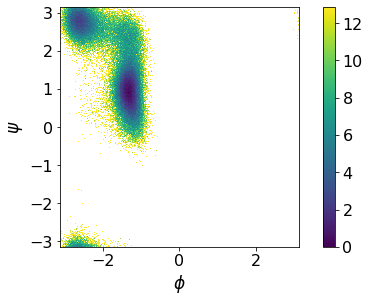

 18%|██████████████████████████▎                                                                                                                    | 9/49 [00:30<00:41,  1.05s/it]

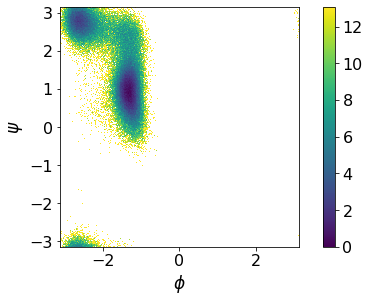

 20%|████████████████████████████▉                                                                                                                 | 10/49 [00:31<00:35,  1.11it/s]

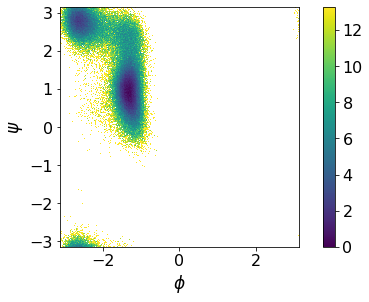

 22%|███████████████████████████████▉                                                                                                              | 11/49 [00:31<00:29,  1.27it/s]

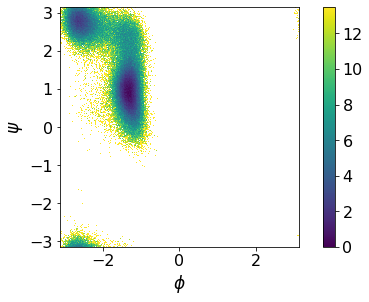

 24%|██████████████████████████████████▊                                                                                                           | 12/49 [00:32<00:26,  1.40it/s]

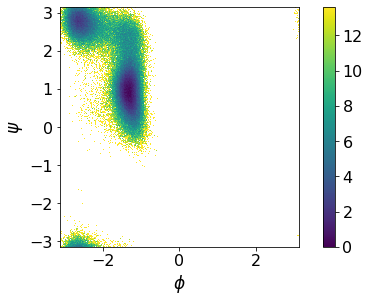

 27%|█████████████████████████████████████▋                                                                                                        | 13/49 [00:32<00:23,  1.53it/s]

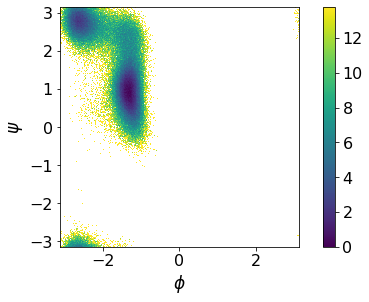

 29%|████████████████████████████████████████▌                                                                                                     | 14/49 [00:33<00:21,  1.64it/s]

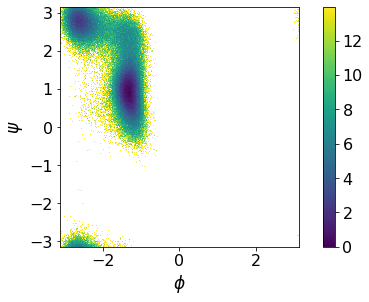

 31%|███████████████████████████████████████████▍                                                                                                  | 15/49 [00:33<00:19,  1.78it/s]

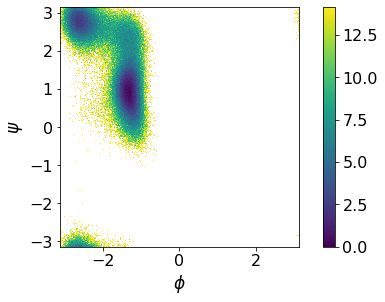

 33%|██████████████████████████████████████████████▎                                                                                               | 16/49 [00:34<00:17,  1.86it/s]

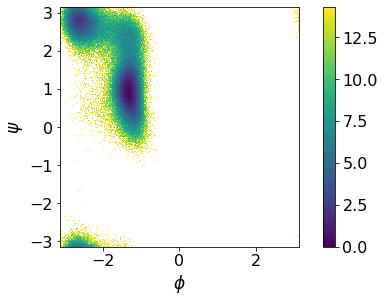

 35%|█████████████████████████████████████████████████▎                                                                                            | 17/49 [00:34<00:16,  1.90it/s]

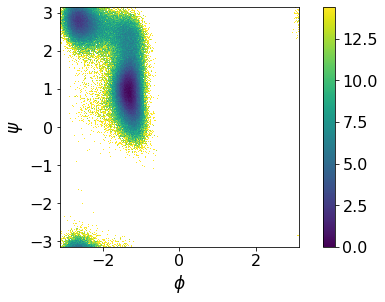

 37%|████████████████████████████████████████████████████▏                                                                                         | 18/49 [00:35<00:15,  1.95it/s]

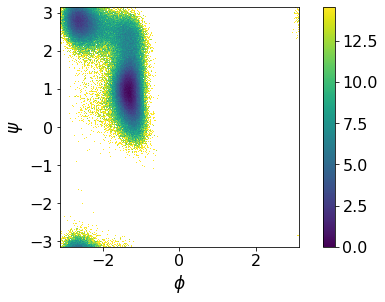

 39%|███████████████████████████████████████████████████████                                                                                       | 19/49 [00:35<00:14,  2.02it/s]

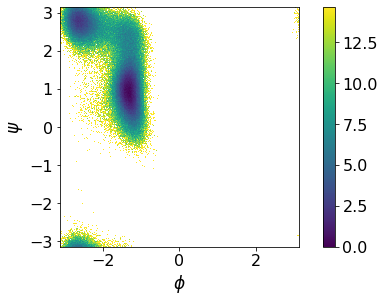

 41%|█████████████████████████████████████████████████████████▉                                                                                    | 20/49 [00:36<00:14,  2.03it/s]

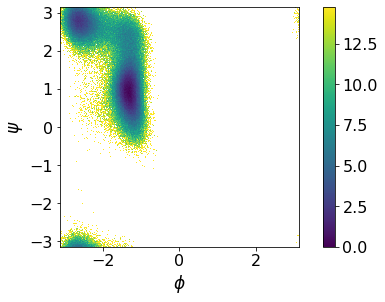

 43%|████████████████████████████████████████████████████████████▊                                                                                 | 21/49 [00:36<00:13,  2.04it/s]

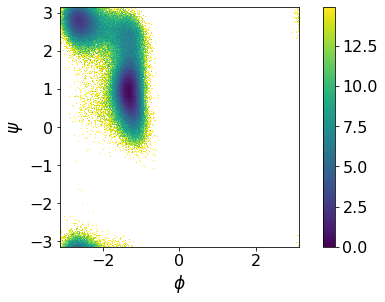

 45%|███████████████████████████████████████████████████████████████▊                                                                              | 22/49 [00:36<00:13,  2.07it/s]

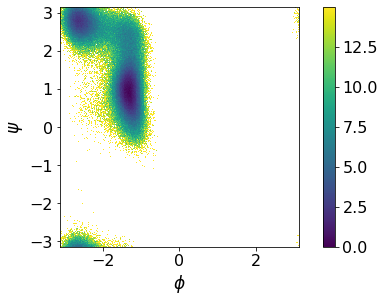

 47%|██████████████████████████████████████████████████████████████████▋                                                                           | 23/49 [00:37<00:13,  1.99it/s]

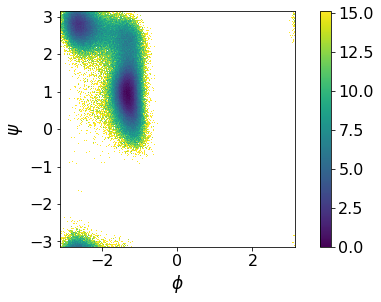

 49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 24/49 [00:38<00:12,  1.99it/s]

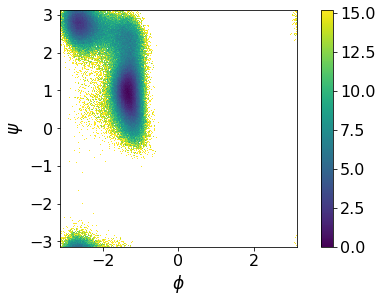

 51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 25/49 [00:38<00:12,  1.95it/s]

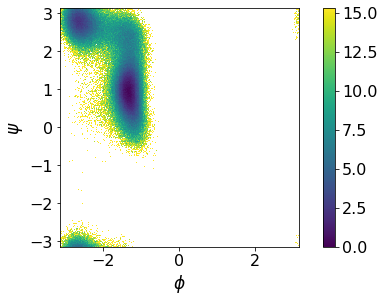

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 26/49 [00:39<00:11,  1.93it/s]

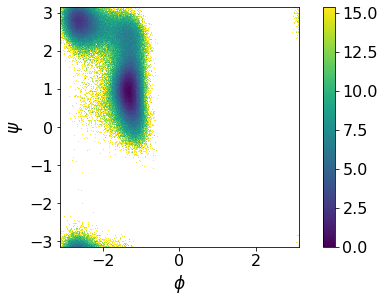

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                               | 27/49 [00:39<00:11,  1.88it/s]

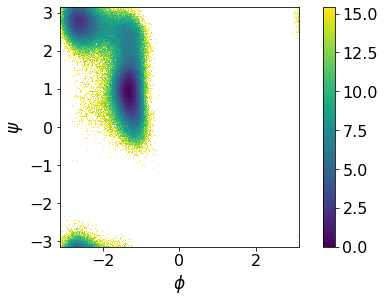

 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                            | 28/49 [00:40<00:11,  1.86it/s]

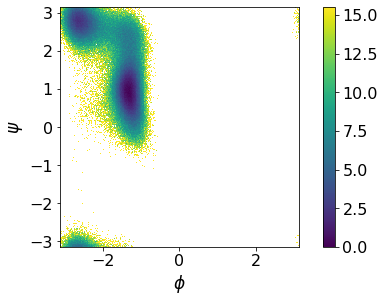

 59%|████████████████████████████████████████████████████████████████████████████████████                                                          | 29/49 [00:40<00:10,  1.92it/s]

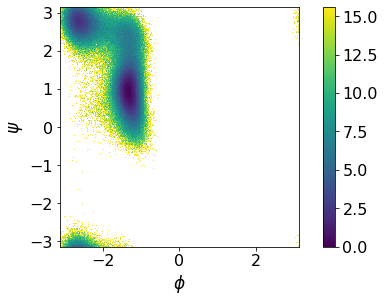

 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                       | 30/49 [00:41<00:10,  1.76it/s]

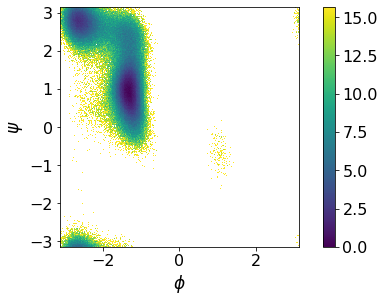

 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 31/49 [00:41<00:10,  1.75it/s]

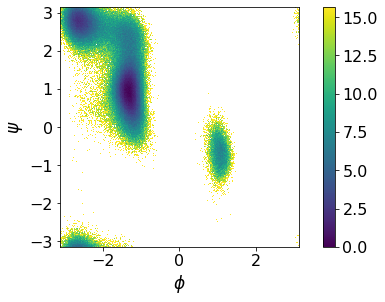

 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 32/49 [00:44<00:18,  1.08s/it]

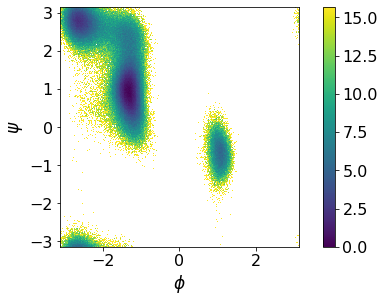

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 33/49 [00:48<00:30,  1.90s/it]

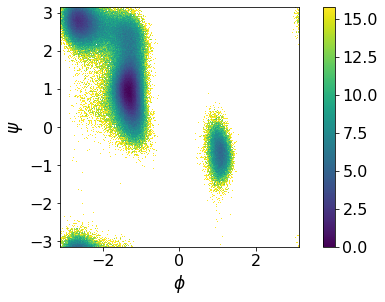

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 34/49 [00:48<00:23,  1.56s/it]

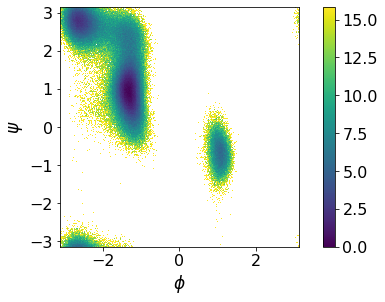

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 35/49 [00:49<00:17,  1.27s/it]

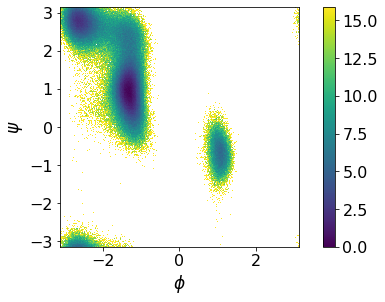

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 36/49 [00:49<00:13,  1.07s/it]

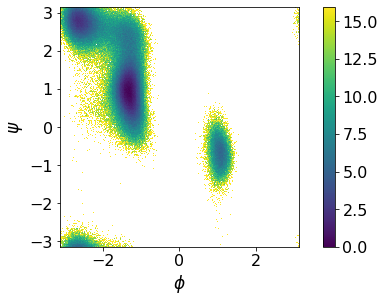

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 37/49 [00:50<00:11,  1.08it/s]

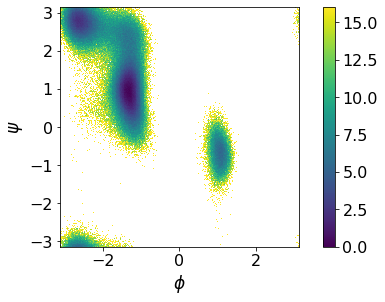

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 38/49 [00:51<00:08,  1.24it/s]

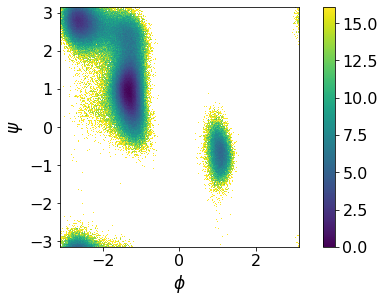

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 39/49 [00:51<00:07,  1.35it/s]

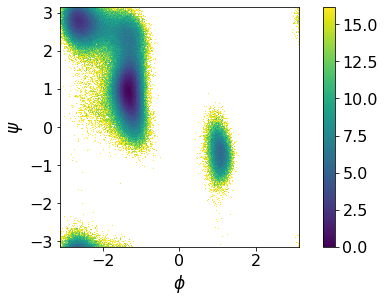

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 40/49 [00:52<00:06,  1.47it/s]

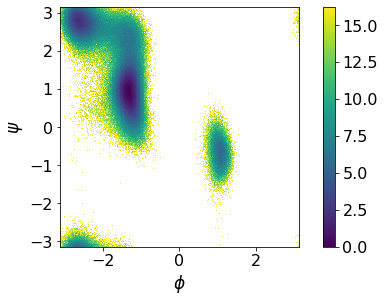

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 41/49 [00:52<00:05,  1.56it/s]

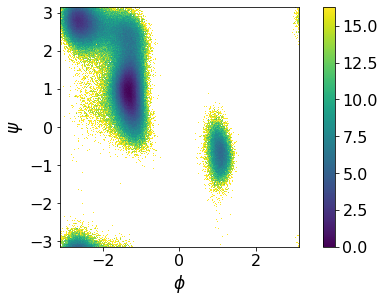

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 42/49 [00:53<00:04,  1.69it/s]

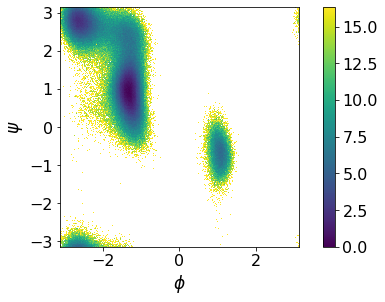

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 43/49 [00:53<00:03,  1.77it/s]

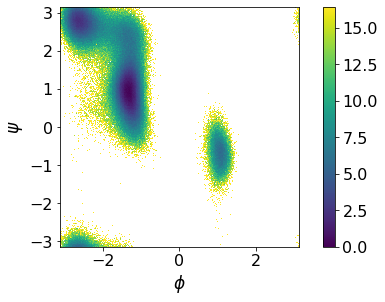

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 44/49 [00:54<00:02,  1.84it/s]

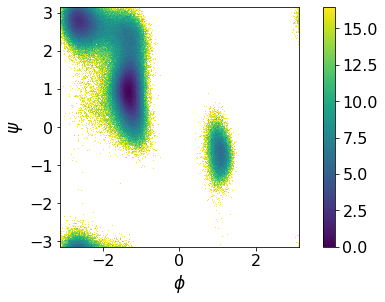

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 45/49 [00:54<00:02,  1.94it/s]

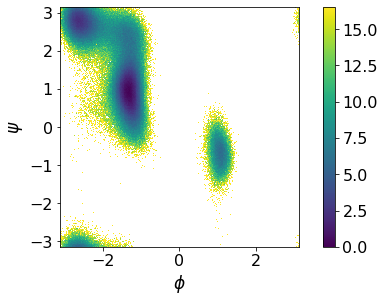

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 46/49 [00:55<00:01,  1.95it/s]

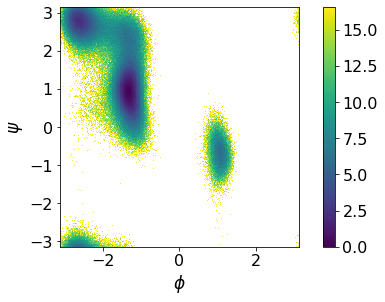

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 47/49 [00:55<00:01,  1.91it/s]

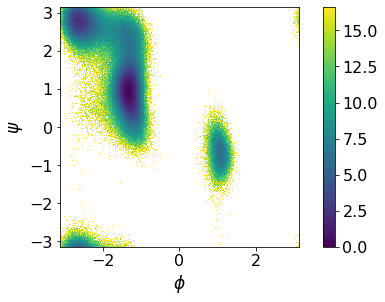

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:56<00:00,  1.93it/s]

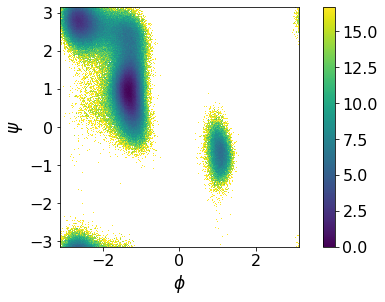

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:56<00:00,  1.16s/it]


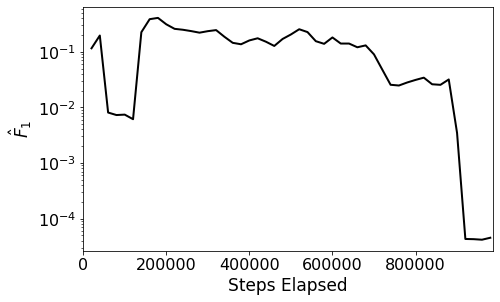

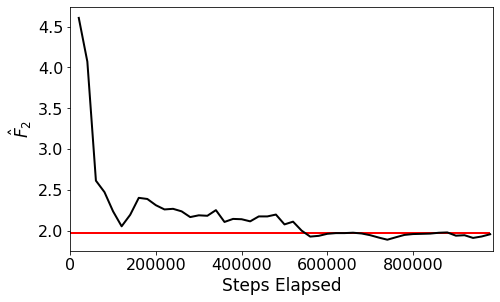

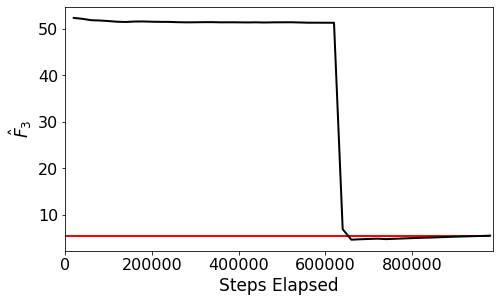

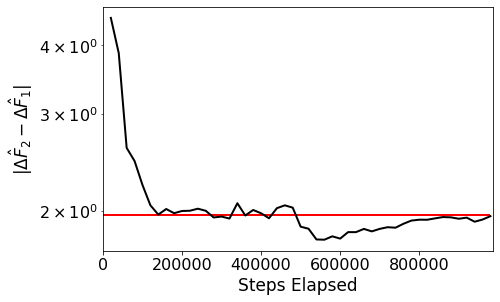

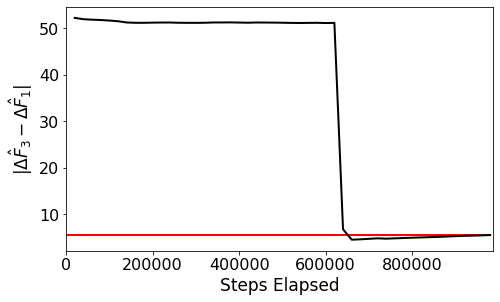

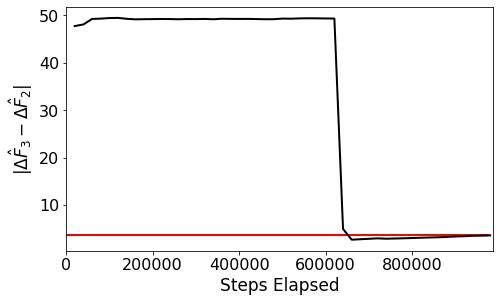

In [135]:
ConvergenceAnalyser(minimum1, minimum2, minimum3, alanine_exp_1us.dihedral_traj, alanine_exp_1us.beta).plot_anomaly()

No handles with labels found to put in legend.


/home/dominic/PycharmProjects/mdfeature/notebooks


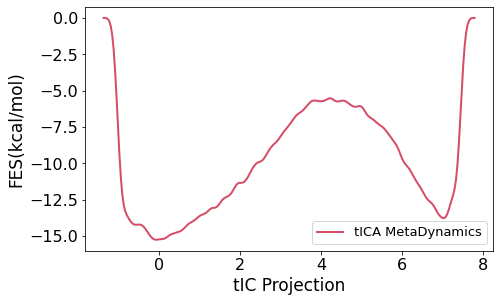

In [21]:
ax=plt.subplot(1,1,1)
ax.legend()
#plt.ylim([0,10])
plt.xlabel("tIC Projection")
plt.ylabel("FES(kcal/mol)")
print(os.getcwd())
data = np.loadtxt("../CSD3scripts/TICA/fes.dat")
plt.plot(data[:,0],data[:,1]/4.184,label="tICA MetaDynamics",c='#d64d67')
plt.xlabel("tIC Projection")
plt.ylabel("FES(kcal/mol)")
#plt.ylim([0,10])
plt.legend()
#plt.xlim([-1.5,8])

7 NaNs detected, removing rows with NaNs.
[3.19476223e+17 7.71938347e+17 6.42711665e+17 ... 3.34736118e+17
 1.34360821e+11 6.24850460e+16]


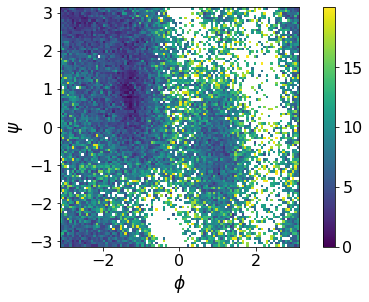

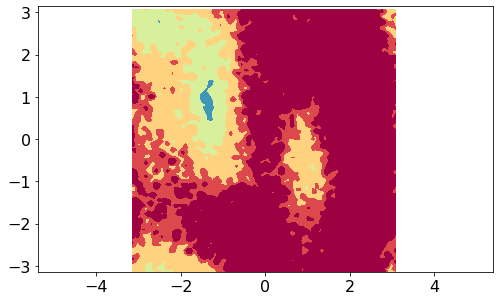

In [202]:
import plotly.express as px
import scipy.ndimage as ndimage
array, df = exp_orig_tica1.ramachandran_plot(rotate=False, nan_threshold=20)

def array_to_dataframe(array, x_label='x', y_label='y'):
    df_wide = pd.DataFrame(array)
    df_wide.index.name = x_label
    df_wide.reset_index(inplace=True)
    df_long = df_wide.melt(id_vars='x', value_vars=df_wide.columns.to_list()).rename(columns = {'variable':y_label})
    
    return df_long

final_df = array_to_dataframe(array)
    
    
X = np.arange(-np.pi, np.pi, 2*np.pi/100)
Y = np.arange(-np.pi, np.pi, 2*np.pi/100)
Z = array
Z2 = ndimage.gaussian_filter(Z, sigma=0.75, order=0)
plt.contourf(X,Y,Z2, levels=20, vmin=0, vmax=10, cmap = 'Spectral_r')
plt.axis('equal')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.show()
#plt.contour(X,Y,Z,levels=levels)
# Plotly.newPlot('graph', [{
#   type: 'histogram2dcontour',
#   x: df.phi,
#   y: df.psi,
#   histfunc: 'avg',  // or 'sum', 'min', 'max
#   z: [1,1,1e3,1e3,1,1]
# }])
# fig = px.density_contour(final_df, x='x', y = 'y', z='value', histfunc='avg')
# fig.update_traces(contours_coloring="fill", contours_showlabels = True)
# fig.show()

In [5]:
alanine_dmap = dill.load(open('../data/outputs/alanine_1us/alanine_exp_1us_s2_dm.pickle','rb')).DMAP

In [19]:
location = '../data/outputs/alanine_1us'
dihedral_pickle_file = 'alanine_1us_dihedral_traj.pickle'
temperature = 300
duration = "987.036ns" 
savefreq = "1ps"
stepsize = "2fs"
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]
default_torsions = [phi, psi, zeta, theta]
alanine_exp_1us_w_dmap = Experiment(location = location, 
                              dihedral_pickle_file = dihedral_pickle_file,
                              temperature = temperature,
                              duration = duration,
                              savefreq = savefreq,
                              stepsize = stepsize,
                              default_torsions=default_torsions
                              )

Successfully initialised experiment metadata.
Successfully loaded experiment data.
Successfully featurized trajectory.


In [20]:
alanine_exp_1us_w_dmap.DMAP = alanine_dmap

In [17]:
test = np.zeros([4,2])
print(test)
test[0][0] = 4
test[2][0] = 8
test[0][1] = -4
test[2][1] = -8
print(test)
print(test[::2,:])

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[ 4. -4.]
 [ 0.  0.]
 [ 8. -8.]
 [ 0.  0.]]
[[ 4. -4.]
 [ 8. -8.]]


In [21]:
alanine_exp_1us_w_dmap.compute_PCA(dim=3)
print(alanine_exp_1us_w_dmap.featurized_trajectory.shape)
alanine_exp_1us_w_dmap.create_plumed_metadynamics_script(CV='DMAP', filename='plumed_DMAP_1us_stride_2')

Computed PCA in 0.063s.
(987036, 8)
plumed_script="RESTART \n\
[-0.00016758 -0.00016758 -0.00016758 ... -0.00016758 -0.00016758
 -0.00016758]
(493518,)
a_shape (987036, 9)
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 \n\
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 \n\
TORSION ATOMS=2,5,7,9 LABEL=2_5_7_9 \n\
TORSION ATOMS=9,15,17,19 LABEL=9_15_17_19 \n\
MATHEVAL ARG=5_7_9_15 FUNC=cos(x)--0.018100298941135406 LABEL=cos_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=5_7_9_15 FUNC=sin(x)--0.7750170826911926 LABEL=sin_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=cos(x)-0.11455978453159332 LABEL=cos_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=sin(x)-0.5776147246360779 LABEL=sin_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=cos(x)--0.9876720905303955 LABEL=cos_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=sin(x)--0.0018686018884181976 LABEL=sin_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=cos(x)--0.9883973598480225 LABEL=cos_9_15_17_19 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 F

In [ ]:
Computed PCA in 0.248s.
plumed_script="RESTART \n\
[ 1.1606867   1.3386797   1.4454519  ... -0.81000274 -0.87689567
  0.77636606]
(987036,)
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 \n\
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 \n\
TORSION ATOMS=2,5,7,9 LABEL=2_5_7_9 \n\
TORSION ATOMS=9,15,17,19 LABEL=9_15_17_19 \n\
MATHEVAL ARG=5_7_9_15 FUNC=cos(x)--0.018100298941135406 LABEL=cos_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=5_7_9_15 FUNC=sin(x)--0.7750170826911926 LABEL=sin_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=cos(x)-0.11455978453159332 LABEL=cos_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=sin(x)-0.5776147246360779 LABEL=sin_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=cos(x)--0.9876720905303955 LABEL=cos_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=sin(x)--0.0018686018884181976 LABEL=sin_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=cos(x)--0.9883973598480225 LABEL=cos_9_15_17_19 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=sin(x)--0.004300905857235193 LABEL=sin_9_15_17_19 PERIODIC=NO \n\
COMBINE LABEL=PCA_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_17,cos_2_5_7_9,sin_2_5_7_9,cos_9_15_17_19,sin_9_15_17_19 COEFFICIENTS=-0.5233437836034278,0.14863186024723976,-0.8323598980242899,-0.10014450000828198,2.8964499312778003e-05,0.03174602265864699,-0.00016289310381917277,0.01265291173498418 PERIODIC=NO \n\
METAD ARG=PCA_0 SIGMA=0.1 HEIGHT=0.2 FILE=HILLS PACE=1000 LABEL=metad \n\
PRINT ARG=PCA_0,metad.bias STRIDE=1000 FILE=COLVAR \n"

(40000, 5)
[[-3.14     -3.14      1.770466 -0.043017 18.617401]
 [-3.1086   -3.14      1.77368   0.394715 19.107293]
 [-3.0772   -3.14      1.811041  2.228657 19.523237]
 ...
 [ 3.0458    3.1086    1.125163  0.460175 16.744802]
 [ 3.0772    3.1086    1.151825  1.100821 17.878603]
 [ 3.1086    3.1086    1.184684  0.79758  17.845371]]


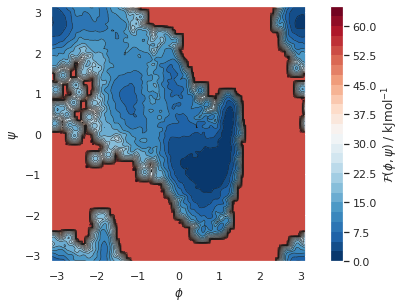

In [300]:
def ramachandran_from_file(file, rotate=True):
    A = np.genfromtxt(file, delimiter=' ')
    A[A == np.inf] = 50
    num_levels = int(np.floor((np.max(A[:,2])-np.min(A[:,2])) / 2.5))
    levels = [k * 2.5 for k in range(num_levels+2)]
    ramachandran_from_x_y_z(A[:,0],A[:,1],A[:,2]-np.min(A[:,2]),rotate=rotate,levels=levels)
    print(A.shape)
    print(A)

ramachandran_from_file(file="/home/dominic/PycharmProjects/mdfeature/CSD3scripts/long_experiments/ff.dat",
                      rotate=False)

(40000, 5)
[[-3.14     -3.14      3.263589 -8.131653 14.275424]
 [-3.1086   -3.14      3.063743 -4.233783 11.085967]
 [-3.0772   -3.14      3.00774   0.558239  8.440797]
 ...
 [ 3.0458    3.1086    3.383399 -7.221129 17.311117]
 [ 3.0772    3.1086    3.182594 -6.037057 18.393592]
 [ 3.1086    3.1086    2.988358 -6.30466  17.304938]]


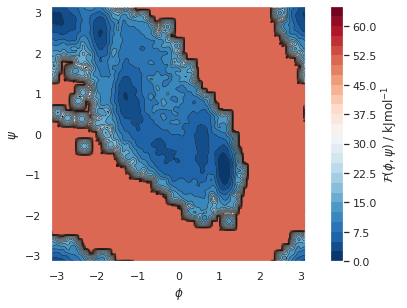

In [303]:
ramachandran_from_file(file="/home/dominic/PycharmProjects/mdfeature/CSD3scripts/long_experiments/ff_TICA1.dat",
                      rotate=False)

In [115]:
import time
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import timedelta
from collections import defaultdict
from scipy.interpolate import griddata
import openmm.unit as unit
import subprocess
from tqdm import tqdm

unit_labels = {
    "us": unit.microseconds,
    "ns": unit.nanoseconds,
    "ps": unit.picoseconds,
    "fs": unit.femtoseconds
}


def parse_quantity(s):
    try:
        u = s.lstrip('0123456789.')
        v = s[:-len(u)]
        return unit.Quantity(
            float(v),
            unit_labels[u]
        )
    except Exception:
        raise ValueError(f"Invalid quantity: {s}")


class ExperimentOrganiser():

    def __init__(self,
                 directory,
                 methods,
                 number_of_repeats,
                 critical_points,
                 points_on_covergence_plot,
                 fe_grid_size,
                 simulation_length,
                 save_frequency,
                 step_size,
                 simulations_complete=False):

        self.initialised = False
        self.simulations_complete = simulations_complete
        self.FES_constructed = False
        self.fe_vals_computed = False
        self.fe_vals_summarised = False

        self.methods = methods
        self.number_of_repeats = number_of_repeats
        self.set_points_on_convergence_plot(points_on_covergence_plot)
        self.fe_grid_size = fe_grid_size
        self.openmm_simulation_length = simulation_length
        self.openmm_save_frequency = save_frequency
        self.openmm_step_size = step_size
        self.simulation_length = parse_quantity(simulation_length)
        self.save_frequency = parse_quantity(save_frequency)
        self.step_size = parse_quantity(step_size)
        self.stride = int(self.save_frequency / self.step_size)
        print("stride", self.stride)

        self.dir = directory
        # change working directory
        os.chdir(self.dir)
        self.critical_points = critical_points
        self.critical_point_labels = [critical_point[0] for critical_point in self.critical_points]

        self.eta = None
        self.exps_ran = 0
        self.cumulative_time = 0
        self.total_exps = len(self.methods) * number_of_repeats

        #                    method              fraction            repeat           grid matrix
        self.raw_grid_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.zeros(0))))
        #              method              critical point      fraction            repeat              value
        self.fe_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0))))
        #                  method              critical point       [[mean, std], ...]
        self.avg_fe_data = defaultdict(lambda: defaultdict(lambda: []))

        self.conver_x_data = [frac * self.simulation_length for frac in self.fractions]

    def set_points_on_convergence_plot(self, points_on_convergence_plot):
        self._points_on_convergence_plot = points_on_convergence_plot
        self.fractions = [round((idx + 1) / self._points_on_convergence_plot, 3) for idx in
                          range(self._points_on_convergence_plot)]

    def progress_logger(self, ti, tf):
        if self.exps_ran == 0:
            print("Running first experiment. ETA will be computed after completion.")
        else:
            self.cumulative_time += (tf - ti)
            exps_remaining = self.total_exps - self.exps_ran
            average_time_per_exp = self.cumulative_time / self.exps_ran
            eta = average_time_per_exp * exps_remaining
            eta_str = str(timedelta(seconds=eta))
            print(f"ETA: {eta_str} Completed {self.exps_ran}/{self.total_exps} experiments.")

    # 1)
    def initialise_hills_and_PLUMED(self):
        for method in self.methods:
            for repeat in range(self.number_of_repeats):
                open(f"{self.dir}/HILLS_{method}{repeat}", "w")
                open(f"{self.dir}/COLVAR_{method}{repeat}", "w")
                with open(f"{self.dir}/{method}{repeat}.txt", "w") as f:
                    PLUMED_string = self.PLUMED(method, repeat)
                    f.write(PLUMED_string)
        self.initialised = True

    # 2)
    def run_openmm_experiments(self):
        ti = None
        tf = None
        assert self.initialised == True
        for repeat in range(self.number_of_repeats):
            for method in self.methods:
                self.progress_logger(ti, tf)
                ti = time.time()
                exp_name = self.get_exp_name(method, repeat)
                # add exp name option to run_openmm
                subprocess.call(
                    f"{self.dir}/run_openmm.py alanine.pdb amber -d {self.openmm_simulation_length} -f {self.openmm_save_frequency} -s {self.openmm_step_size} "
                    f"-p -mdm {method} -repeat {repeat + 1} -seed {repeat} -name {exp_name} -dir {self.dir}",
                    shell=True, stdout=subprocess.DEVNULL)
                subprocess.call(
                    f"mdconvert {self.dir}/{exp_name}/trajectory.dcd -o {self.dir}/{exp_name}/trajectory.xtc",
                    shell=True, stdout=subprocess.DEVNULL)
                tf = time.time()
                self.exps_ran += 1
        self.simulations_complete = True

    @staticmethod
    def get_exp_name(method: str, repeat: int):
        return method + str(repeat)

    # 3)
    def run_analysis(self):
        print("Loading FES...")
        self.load_FESs()
        print("Extracting FE values...")
        self.extract_fe_vals()
        print("Summarising FE data...")
        self.summarise_fe_data()
        print("Making convergence plots...")
        #self.make_convergence_plots()

    # a)
    def load_FESs(self):
        with tqdm(total=len(self.methods * self.number_of_repeats * len(self.fractions))) as pbar:
            assert self.simulations_complete == True
            for method in self.methods:
                for repeat in range(self.number_of_repeats):
                    for fraction in self.fractions:
                        self.load_exp_FES(method, repeat, fraction)
                        pbar.update(1)
            self.FES_constructed = True

    def load_exp_FES(self, method, repeat, fraction):
        new_HILLS_file_name = self.construct_trimmed_HILLS_file(method, repeat, fraction)
        exp_name = self.run_reweighting(method, repeat, fraction)
        #os.remove(new_HILLS_file_name)
        self.raw_grid_data[method][fraction][repeat] = np.genfromtxt(f"{self.dir}/ff_{exp_name}_{fraction}.dat",
                                                                     delimiter=' ', autostrip=True)

    @staticmethod
    def read_HILLS_file(file, skipinitial=3):
        HILLS_arr = []
        HILLS_strs = []
        HILLS_header = []
        with open(file, "r") as f:
            for idx, line in enumerate(f.readlines()):
                if idx < skipinitial:
                    HILLS_header.append(line)
                else:
                    entries = [float(segment.strip()) for segment in line.split()]
                    HILLS_arr.append(entries)
                    HILLS_strs.append(line)

        return np.array(HILLS_arr), HILLS_strs, HILLS_header

    def construct_trimmed_HILLS_file(self, method, repeat, fraction):
        HILLS_file = f"{self.dir}/HILLS_{method}{repeat}"
        HILLS_arr, HILLS_strs, HILLS_header = self.read_HILLS_file(HILLS_file, skipinitial=3)
        lines_in_arr = len(HILLS_strs)
        lines_to_keep = int(fraction * lines_in_arr)
        trimmed_HILLS_strs = HILLS_strs[:lines_to_keep]

        new_HILLS_file = HILLS_file + "_" + str(fraction)
        with open(new_HILLS_file, "w") as f:
            for line in HILLS_header:
                f.write(line)
            for line in trimmed_HILLS_strs:
                f.write(line)

        # filename
        return new_HILLS_file

    def run_reweighting(self, method, repeat, fraction):
        exp_name = self.get_exp_name(method, repeat)
        with open(f"{self.dir}/plumed_reweight_{exp_name}_{fraction}.dat", "w") as f:
            PLUMED_reweight_string = self.REWEIGHT_PLUMED(method, repeat, fraction)
            f.write(PLUMED_reweight_string)
        subprocess.call(
            f"plumed driver --mf_xtc {self.dir}/{exp_name}/trajectory.xtc --plumed {self.dir}/plumed_reweight_{exp_name}_{fraction}.dat",
            shell=True)

        return exp_name

    @staticmethod
    def get_header(file, num_lines):
        with open(file, "r") as f:
            head = [next(f) for _ in range(num_lines)]

        return head

    # b)
    def extract_fe_vals(self):
        assert self.FES_constructed == True
        for method in self.methods:
            for repeat in range(self.number_of_repeats):
                for fraction in self.fractions:
                    phi, psi, fe = self.get_fe_grid_of_exp(method, repeat, fraction)
                    fe_grid = self.convert_xyz_to_numpy_grid(phi, psi, fe)
                    self.compute_critical_point_free_energys(fe_grid, method, repeat, fraction)
        self.fe_vals_computed = True

    def get_fe_grid_of_exp(self, method, repeat, fraction):
        data = self.raw_grid_data[method][fraction][repeat]
        phi = data[:, 0]
        psi = data[:, 1]
        fe = data[:, 2] - np.min(data[:, 2])
        return phi, psi, fe

    def convert_xyz_to_numpy_grid(self, x, y, z):
        grid_x, grid_y = np.mgrid[-np.pi:np.pi:complex(0, self.fe_grid_size), -np.pi:np.pi:complex(0, self.fe_grid_size)]
        points = np.column_stack((x, y))
        return griddata(points, z, (grid_x, grid_y), method='linear')

    # c)
    def summarise_fe_data(self):
        assert self.fe_vals_computed == True
        for method in self.methods:
            for critical_point in self.critical_point_labels:
                for fraction in self.fractions:
                    running_list = []
                    for repeat in range(self.number_of_repeats):
                        running_list.append(self.fe_data[method][critical_point][fraction][repeat])
                    mean = np.mean(running_list)
                    std = np.std(running_list)
                    self.avg_fe_data[method][critical_point].append([mean, std])

        self.fe_vals_summarised = True

    def compute_critical_point_free_energys(self, fe_grid, method, repeat, fraction):
        for critical_point in self.critical_points:
            phi_crit = critical_point[1]
            psi_crit = critical_point[2]
            estimated_fe = self.grid_interpolate(fe_grid, phi_crit, psi_crit)
            self.save_fe_energy_estimate(method, repeat, fraction, critical_point[0], estimated_fe)

    def grid_interpolate(self, grid, x, y):
        x_cell = ((x + np.pi) / (2 * np.pi)) * (self.fe_grid_size-1)
        y_cell = ((y + np.pi) / (2 * np.pi)) * (self.fe_grid_size-1)

        lower_interpolant = (x_cell - int(np.floor(x_cell))) * grid[
            int(np.floor(x_cell)) + 1, int(np.floor(y_cell))] + (
                                    1 - x_cell + int(np.floor(x_cell))) * grid[
                                int(np.floor(x_cell)), int(np.floor(y_cell))]
        upper_interpolant = (x_cell - int(np.floor(x_cell))) * grid[
            int(np.floor(x_cell)) + 1, int(np.floor(y_cell)) + 1] + (
                                    1 - x_cell + int(np.floor(x_cell))) * grid[
                                int(np.floor(x_cell)), int(np.floor(y_cell)) + 1]

        final_interpolant = (y_cell - int(np.floor(y_cell))) * upper_interpolant + (
                1 - y_cell + int(np.floor(y_cell))) * lower_interpolant

        return final_interpolant

    def save_fe_energy_estimate(self, method, repeat, fraction, critical_point, value):
        self.fe_data[method][critical_point][fraction][repeat] = value

    def make_convergence_plots(self):
        assert self.fe_vals_summarised == True
        for method in self.methods:
            self.convergence_plot(method)

    def convergence_plot(self, method):
        for critical_point in self.critical_point_labels:
            plt.plot([val.value_in_unit(unit.nanoseconds) for val in self.conver_x_data], [val[0] for val in self.avg_fe_data[method][critical_point]],
                     label=critical_point)

        # TODO: fill between
        plt.xlabel('Elapsed Time (ns)', fontsize=18)
        plt.ylabel(r'$\log\left(F-\hat{F}\right)$', fontsize=18)
        plt.yscale('log')
        plt.legend()
        plt.show()
        # TODO: save plot

    def PLUMED(self, method, repeat):
        prefix = f"RESTART \n\
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 \n\
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 \n\
TORSION ATOMS=2,5,7,9 LABEL=2_5_7_9 \n\
TORSION ATOMS=9,15,17,19 LABEL=9_15_17_19 \n\
MATHEVAL ARG=5_7_9_15 FUNC=cos(x)--0.018100298941135406 LABEL=cos_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=5_7_9_15 FUNC=sin(x)--0.7750170826911926 LABEL=sin_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=cos(x)-0.11455978453159332 LABEL=cos_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=sin(x)-0.5776147246360779 LABEL=sin_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=cos(x)--0.9876720905303955 LABEL=cos_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=sin(x)--0.0018686018884181976 LABEL=sin_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=cos(x)--0.9883973598480225 LABEL=cos_9_15_17_19 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=sin(x)--0.004300905857235193 LABEL=sin_9_15_17_19 PERIODIC=NO \n\
"
        if method == "TICA":
            return prefix + f"COMBINE LABEL=TICA_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_17,cos_2_5_7_9,sin_2_5_7_9,cos_9_15_17_19,sin_9_15_17_19 COEFFICIENTS=0.34064384071734,0.92966430112022,0.0161593856858182,-0.026732070218086,0.124684184179194,-0.054801458726274,-0.0042902856957667,0.0119406643788291 PERIODIC=NO \n\
METAD ARG=TICA_0 SIGMA=0.1 HEIGHT=1.2 BIASFACTOR=8 TEMP=300 FILE=HILLS_TICA{repeat} PACE=500 LABEL=metad \n\
PRINT ARG=TICA_0,metad.bias STRIDE={self.stride} FILE=COLVAR_TICA{repeat} \n"
        elif method == "PCA":
            return prefix + f"COMBINE LABEL=PCA_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_17,cos_2_5_7_9,sin_2_5_7_9,cos_9_15_17_19,sin_9_15_17_19 COEFFICIENTS=-0.5233437836034278,0.14863186024723976,-0.8323598980242899,-0.10014450000828198,2.8964499312778003e-05,0.03174602265864699,-0.00016289310381917277,0.01265291173498418 PERIODIC=NO \n\
METAD ARG=PCA_0 SIGMA=0.1 HEIGHT=1.2 BIASFACTOR=8 TEMP=300 FILE=HILLS_PCA{repeat} PACE=500 LABEL=metad \n\
PRINT ARG=PCA_0,metad.bias STRIDE={self.stride} FILE=COLVAR_PCA{repeat} \n"
        elif method == "VAMP":
            return prefix + f"COMBINE LABEL=VAMP_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_17,cos_2_5_7_9,sin_2_5_7_9,cos_9_15_17_19,sin_9_15_17_19 COEFFICIENTS=0.339774471816777,0.930293229662793,0.01633229139417103,-0.0254281296973736,0.1227416304730610,-0.0544009983962363,-0.00522093244037105,0.01192673508843518 PERIODIC=NO \n\
METAD ARG=VAMP_0 SIGMA=0.1 HEIGHT=1.2 BIASFACTOR=8 TEMP=300 FILE=HILLS_VAMP{repeat} PACE=500 LABEL=metad \n\
PRINT ARG=VAMP_0,metad.bias STRIDE={self.stride} FILE=COLVAR_VAMP{repeat} \n"
        elif method == "DMAP":
            return prefix + f"COMBINE LABEL=DMAP_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_17,cos_2_5_7_9,sin_2_5_7_9,cos_9_15_17_19,sin_9_15_17_19 COEFFICIENTS=-0.341182884310888,-0.93079433857876,-0.015982887915466,0.026217148677748,-0.11462269900346,0.0539851347818776,-0.0088330576090523,-0.01194011395056 PERIODIC=NO \n\
METAD ARG=DMAP_0 SIGMA=0.1 HEIGHT=1.2 BIASFACTOR=8 TEMP=300 FILE=HILLS_DMAP{repeat} PACE=500 LABEL=metad \n\
PRINT ARG=DMAP_0,metad.bias STRIDE={self.stride} FILE=COLVAR_DMAP{repeat} \n"

    def REWEIGHT_PLUMED(self, method, repeat, fraction):
        prefix = f"RESTART \n\
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 \n\
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 \n\
TORSION ATOMS=2,5,7,9 LABEL=2_5_7_9 \n\
TORSION ATOMS=9,15,17,19 LABEL=9_15_17_19 \n\
MATHEVAL ARG=5_7_9_15 FUNC=cos(x)--0.018100298941135406 LABEL=cos_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=5_7_9_15 FUNC=sin(x)--0.7750170826911926 LABEL=sin_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=cos(x)-0.11455978453159332 LABEL=cos_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=sin(x)-0.5776147246360779 LABEL=sin_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=cos(x)--0.9876720905303955 LABEL=cos_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=sin(x)--0.0018686018884181976 LABEL=sin_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=cos(x)--0.9883973598480225 LABEL=cos_9_15_17_19 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=sin(x)--0.004300905857235193 LABEL=sin_9_15_17_19 PERIODIC=NO \n\
"
        if method == "TICA":
            return prefix + f"COMBINE LABEL=TICA_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_17,cos_2_5_7_9,sin_2_5_7_9,cos_9_15_17_19,sin_9_15_17_19 COEFFICIENTS=0.34064384071734,0.92966430112022,0.0161593856858182,-0.026732070218086,0.124684184179194,-0.054801458726274,-0.0042902856957667,0.0119406643788291 PERIODIC=NO \n\
METAD ARG=TICA_0 SIGMA=0.1 HEIGHT=0.0 FILE=HILLS_TICA{repeat}_{fraction} PACE=10000000 LABEL=metad RESTART=YES \n\
PRINT ARG=TICA_0,metad.bias STRIDE=1 FILE=COLVAR_TICA{repeat}_{fraction}_REWEIGHT \n\
as: REWEIGHT_BIAS ARG=TICA_0  TEMP=300 \n\
hh: HISTOGRAM ARG=5_7_9_15,7_9_15_17 GRID_MIN=-3.14,-3.14 GRID_MAX=3.14,3.14 GRID_BIN={self.fe_grid_size},{self.fe_grid_size} BANDWIDTH=0.05,0.05 LOGWEIGHTS=as \n\
ff: CONVERT_TO_FES GRID=hh TEMP=300 \n\
DUMPGRID GRID=ff FILE=ff_TICA{repeat}_{fraction}.dat"
        elif method == "PCA":
            return prefix + f"COMBINE LABEL=PCA_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_17,cos_2_5_7_9,sin_2_5_7_9,cos_9_15_17_19,sin_9_15_17_19 COEFFICIENTS=-0.5233437836034278,0.14863186024723976,-0.8323598980242899,-0.10014450000828198,2.8964499312778003e-05,0.03174602265864699,-0.00016289310381917277,0.01265291173498418 PERIODIC=NO \n\
METAD ARG=PCA_0 SIGMA=0.1 HEIGHT=0.0 FILE=HILLS_PCA{repeat}_{fraction} PACE=10000000 LABEL=metad RESTART=YES \n\
PRINT ARG=PCA_0,metad.bias STRIDE=1 FILE=COLVAR_PCA{repeat}_{fraction}_REWEIGHT \n\
as: REWEIGHT_BIAS ARG=PCA_0 TEMP=300 \n\
hh: HISTOGRAM ARG=5_7_9_15,7_9_15_17 GRID_MIN=-3.14,-3.14 GRID_MAX=3.14,3.14 GRID_BIN={self.fe_grid_size},{self.fe_grid_size} BANDWIDTH=0.05,0.05 LOGWEIGHTS=as \n\
ff: CONVERT_TO_FES GRID=hh TEMP=300 \n\
DUMPGRID GRID=ff FILE=ff_PCA{repeat}_{fraction}.dat"
        elif method == "VAMP":
            return prefix + f"COMBINE LABEL=VAMP_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_17,cos_2_5_7_9,sin_2_5_7_9,cos_9_15_17_19,sin_9_15_17_19 COEFFICIENTS=0.339774471816777,0.930293229662793,0.01633229139417103,-0.0254281296973736,0.1227416304730610,-0.0544009983962363,-0.00522093244037105,0.01192673508843518 PERIODIC=NO \n\
METAD ARG=VAMP_0 SIGMA=0.1 HEIGHT=0.0 FILE=HILLS_VAMP{repeat}_{fraction} PACE=10000000 LABEL=metad RESTART=YES \n\
PRINT ARG=VAMP_0,metad.bias STRIDE=1 FILE=COLVAR_VAMP{repeat}_{fraction}_REWEIGHT \n\
as: REWEIGHT_BIAS ARG=VAMP_0 TEMP=300 \n\
hh: HISTOGRAM ARG=5_7_9_15,7_9_15_17 GRID_MIN=-3.14,-3.14 GRID_MAX=3.14,3.14 GRID_BIN={self.fe_grid_size},{self.fe_grid_size} BANDWIDTH=0.05,0.05 LOGWEIGHTS=as \n\
ff: CONVERT_TO_FES GRID=hh TEMP=300 \n\
DUMPGRID GRID=ff FILE=ff_VAMP{repeat}_{fraction}.dat"
        elif method == "DMAP":
            return prefix + f"COMBINE LABEL=DMAP_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_17,cos_2_5_7_9,sin_2_5_7_9,cos_9_15_17_19,sin_9_15_17_19 COEFFICIENTS=-0.341182884310888,-0.93079433857876,-0.015982887915466,0.026217148677748,-0.11462269900346,0.0539851347818776,-0.0088330576090523,-0.01194011395056 PERIODIC=NO \n\
METAD ARG=DMAP_0 SIGMA=0.1 HEIGHT=0.0 FILE=HILLS_DMAP{repeat}_{fraction} PACE=10000000 LABEL=metad RESTART=YES \n\
PRINT ARG=DMAP_0,metad.bias STRIDE=1 FILE=COLVAR_DMAP{repeat}_{fraction}_REWEIGHT \n\
as: REWEIGHT_BIAS ARG=DMAP_0 TEMP=300 \n\
hh: HISTOGRAM ARG=5_7_9_15,7_9_15_17 GRID_MIN=-3.14,-3.14 GRID_MAX=3.14,3.14 GRID_BIN={self.fe_grid_size},{self.fe_grid_size} BANDWIDTH=0.05,0.05 LOGWEIGHTS=as \n\
ff: CONVERT_TO_FES GRID=hh TEMP=300 \n\
DUMPGRID GRID=ff FILE=ff_DMAP{repeat}_{fraction}.dat"

In [117]:
def convergence_plot(self, method):
    for critical_point in self.critical_point_labels:
        plt.plot([val.value_in_unit(unit.nanoseconds) for val in self.conver_x_data], [val[0] for val in self.avg_fe_data[method][critical_point]],
                 label=critical_point)

    # TODO: fill between
    plt.xlabel('Elapsed Time (ns)', fontsize=18)
    plt.ylabel(r'$\log\left(F-\hat{F}\right)$', fontsize=18)
    plt.yscale('log')
    plt.legend()
    plt.show()
    # TODO: save plot

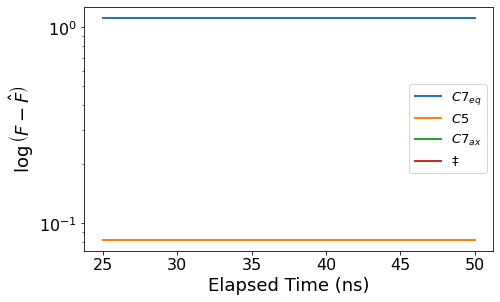

In [121]:
convergence_plot(my_experiments, method='PCA')

### Tests

1) Hill files generated correctly
2) openMM runs correctly
3) trajectory conversion happens
4) reweighting happens
5) ff generated correctly

In [116]:
my_experiments = ExperimentOrganiser(directory="/home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments",
                                     methods=['PCA', 'TICA', 'VAMP', 'DMAP'],
                                     number_of_repeats=3,
                                     critical_points=[(r"$C7_{eq}$", -1.35, 0.96), (r"$C5$", -2.64, 2.79),
                                                      (r"$C7_{ax}$", 1.09, -0.70), (r"$\ddag$", 0.01, -0.64)],
                                     points_on_covergence_plot=2,
                                     fe_grid_size=200,
                                     simulation_length='50ns',
                                     save_frequency='1ps',
                                     step_size='2fs',
                                     simulations_complete=True)
#my_experiments.initialise_hills_and_PLUMED()
#my_experiments.run_openmm_experiments()
my_experiments.run_analysis()

stride 500
Loading FES...


  0%|                                                                                                                                                       | 0/24 [00:00<?, ?it/s]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/PCA0/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_PCA0_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED: 

  4%|█████▉                                                                                                                                         | 1/24 [00:54<20:53, 54.50s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/PCA0/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_PCA0_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED: 

  8%|███████████▉                                                                                                                                   | 2/24 [02:23<27:21, 74.61s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/PCA1/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_PCA1_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED: 

 12%|█████████████████▉                                                                                                                             | 3/24 [03:16<22:40, 64.77s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/PCA1/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_PCA1_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED: 

 17%|███████████████████████▊                                                                                                                       | 4/24 [04:34<23:24, 70.22s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/PCA2/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_PCA2_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED: 

 21%|█████████████████████████████▊                                                                                                                 | 5/24 [05:32<20:49, 65.76s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/PCA2/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_PCA2_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED: 

 25%|███████████████████████████████████▊                                                                                                           | 6/24 [06:53<21:13, 70.77s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/TICA0/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_TICA0_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 29%|█████████████████████████████████████████▋                                                                                                     | 7/24 [07:44<18:16, 64.51s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/TICA0/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_TICA0_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 33%|███████████████████████████████████████████████▋                                                                                               | 8/24 [09:00<18:11, 68.20s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/TICA1/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_TICA1_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 38%|█████████████████████████████████████████████████████▋                                                                                         | 9/24 [09:52<15:46, 63.13s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/TICA1/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_TICA1_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 42%|███████████████████████████████████████████████████████████▏                                                                                  | 10/24 [11:12<15:55, 68.26s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/TICA2/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_TICA2_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 46%|█████████████████████████████████████████████████████████████████                                                                             | 11/24 [12:04<13:40, 63.12s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/TICA2/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_TICA2_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 50%|███████████████████████████████████████████████████████████████████████                                                                       | 12/24 [13:20<13:24, 67.02s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/VAMP0/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_VAMP0_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 54%|████████████████████████████████████████████████████████████████████████████▉                                                                 | 13/24 [14:11<11:25, 62.33s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/VAMP0/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_VAMP0_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 14/24 [15:49<12:11, 73.16s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/VAMP1/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_VAMP1_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 15/24 [16:45<10:10, 67.83s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/VAMP1/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_VAMP1_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 16/24 [18:16<09:58, 74.79s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/VAMP2/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_VAMP2_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 17/24 [19:08<07:55, 67.93s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/VAMP2/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_VAMP2_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 18/24 [20:23<07:00, 70.13s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/DMAP0/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_DMAP0_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 19/24 [21:22<05:34, 66.81s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/DMAP0/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_DMAP0_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 20/24 [22:47<04:49, 72.41s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/DMAP1/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_DMAP1_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 21/24 [23:38<03:17, 65.79s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/DMAP1/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_DMAP1_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 22/24 [24:53<02:16, 68.47s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/DMAP2/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_DMAP2_0.5.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23/24 [25:44<01:03, 63.49s/it]


DRIVER: Found molfile format trajectory xtc with name /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/DMAP2/trajectory.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: /home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/plumed_reweight_DMAP2_1.0.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [27:02<00:00, 67.61s/it]


Extracting FE values...
Summarising FE data...
Making convergence plots...


In [86]:
my_experiments.initialise_hills_and_PLUMED()

In [87]:
my_experiments.run_openmm_experiments()

Running first experiment. ETA will be computed after completion.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 1 day, 19:50:40.488409 Completed 1/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 1 day, 15:32:49.193523 Completed 2/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 1 day, 11:26:27.400545 Completed 3/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 1 day, 7:35:32.222704 Completed 4/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 1 day, 3:26:57.797669 Completed 5/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 23:38:25.145725 Completed 6/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 19:50:15.952573 Completed 7/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 15:53:58.101468 Completed 8/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 11:54:04.546680 Completed 9/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 7:56:29.923326 Completed 10/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ETA: 3:58:13.399876 Completed 11/12 experiments.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [65]:
my_experiments.run_analysis()

ValueError: Some errors were detected !
    Line #2 (got 55 columns instead of 56)

In [460]:
my_experiments.openmm_save_frequency

'100fs'

In [66]:
import pandas as pd
HILLS_file = "/home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/HILLS_DMAP0"
HILLS_arr = pd.read_csv(HILLS_file, delimiter='\t', skiprows=3)
print(HILLS_arr)

                        1    -0.0160332920719402                    0.1      1.371428571428571                      8
0                        2     -0.109434166966018...                                                                 


In [73]:
def read_HILLS_file(file, skipinitial=3):
    HILLS_arr = []
    HILLS_strs = []
    HILLS_header = []
    with open(file, "r") as f:
        for idx, line in enumerate(f.readlines()):
            if idx < skipinitial:
                HILLS_header.append(line)
            else:
                entries = [float(segment.strip()) for segment in line.split()]
                HILLS_arr.append(entries)
                HILLS_strs.append(line)
                
    return np.array(HILLS_arr), HILLS_strs, HILLS_header


arr, strings, head = read_HILLS_file("/home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/HILLS_DMAP0")

['#! FIELDS time DMAP_0 sigma_DMAP_0 height biasf\n',
 '#! SET multivariate false\n',
 '#! SET kerneltype stretched-gaussian\n']